In [1]:
import os
import string
from collections import Counter
from datetime import datetime

import nltk
import pandas as pd
import matplotlib
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.util import ngrams

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
def my_ngrams(tokens, rg):
    ngrms = []
    for i in range(rg[0], rg[1] + 1):
        ngrms_aux = [ngrm for ngrm in ngrams(tokens, i)]
        ngrms.extend(ngrms_aux)
    return ngrms

# Preparing data

## Selected keywords

In [4]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [5]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [6]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [7]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords = [w.replace('\\', '').lower() for w in keywords]
keywords.sort()

In [8]:
print(keywords)

['beam me up,? scotty', 'chekhov', 'crusher', 'delta vega', 'highly illogical', 'i have been and always shall be your friend', "i'm a doctor,? not a", "i'm giving her all she's got,? captain", 'khaaa+n', 'kirk', 'klingon', 'kobayashi maru', 'live long and prosper', 'llap', 'mccoy', 'nero', 'nuclear wessels', 'nurse chapel', 'orion', 'picard', 'pike', 'prime directive', 'resistance is futile', 'romulan', 'romulan narada', 'sarek', 'scotty', 'set phasers to stun', 'space,? the final frontier', 'spock', 'star fleet', 'star trek', 'stardate', 'starship enterprise', 'sulu', 'the needs of the many outweigh the needs of the few', 'to boldly go where no man has gone before', 'transporter beam', 'uhura', 'vulcan', 'vulcan salute', 'when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth', 'without followers,? evil cannot spread']


## Comments

In [9]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': int,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': int,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna(0)

CPU times: user 30.4 s, sys: 1.2 s, total: 31.6 s
Wall time: 31.6 s


In [10]:
len(reddit_df)

2669814

In [11]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,0,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,0,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,0,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,0,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,0,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


# Analyzing data

## Score

In [12]:
P = 1

### Top

In [13]:
top_scored = reddit_df.sort_values(['score'], ascending=False)[:len(reddit_df) * P // 100]

In [14]:
len(top_scored)

26698

In [15]:
top_scored.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
2428290,Aavenell,"""it is possible to make no mistakes and lose. ...",0,2016-05-08 20:27:50,0,0,1,d2y0xkp,0,t3_4igg2s,6986,AskReddit,6986,2016-05-01,2016-01-01
1891461,Inteli_Gent,dungeons &amp; dragons - - edit: this is my h...,0,2015-08-08 22:33:05,0,0,2,ctwhrrg,0,t3_3gaz4f,6454,AskReddit,6454,2015-08-01,2015-01-01
2663053,Zorthianator,we had a guy in our class that was one of thos...,0,2016-08-29 07:11:11,0,0,0,d7123mt,0,t3_503z1d,6056,AskReddit,6056,2016-08-01,2016-01-01
1417553,acidnisibannac,"**as much as i appreciate it, i've been given ...",0,2014-11-15 13:27:31,0,0.0,6,cm3dn3j,t1_cm3dn3j,t3_2me7l2,5758,explainlikeimfive,5758,2014-11-01,2014-01-01
2624241,Sandwichofdeth,let's not forget the time star trek strapped a...,0,2016-08-11 12:13:18,0,0,0,d6ddros,0,t3_4x7vzi,5718,movies,5718,2016-08-01,2016-01-01


In [16]:
top_scored.ix[2428290]['body']

'"it is possible to make no mistakes and lose. that is not failure; that is life." -  - -cpt. jean-luc picard'

#### Temporal evolution

In [17]:
df_by_month = pd.Series(top_scored.groupby('month')['id'].count())
df_by_month.index.name = None

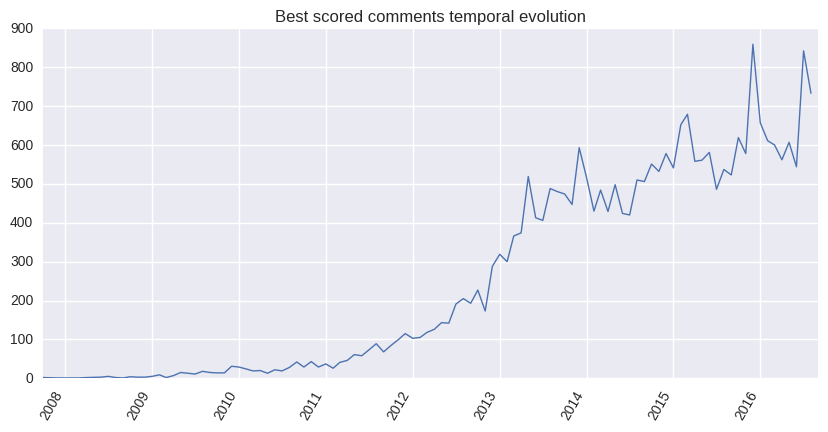

In [18]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=valid_dates,
    rot=60,
    title='Best scored comments temporal evolution',
)
# ax.set_xticklabels(show_dates);

#### Histogram

In [19]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = top_scored['body'].str.count(k).sum()

CPU times: user 2.02 s, sys: 48 ms, total: 2.07 s
Wall time: 2.01 s


In [20]:
keywords_counter = Counter(keywords_dict)

In [21]:
keywords_counter.most_common()

[('star trek', 8834),
 ('kirk', 3985),
 ('picard', 2417),
 ('mccoy', 2006),
 ('spock', 1811),
 ('pike', 1572),
 ('klingon', 1326),
 ('orion', 1304),
 ('nero', 1126),
 ('scotty', 1066),
 ('vulcan', 975),
 ('crusher', 820),
 ('prime directive', 309),
 ('romulan', 291),
 ('chekhov', 291),
 ('resistance is futile', 268),
 ('uhura', 248),
 ('sulu', 231),
 ('khaaa+n', 219),
 ('live long and prosper', 159),
 ('llap', 125),
 ('star fleet', 113),
 ('stardate', 108),
 ('starship enterprise', 100),
 ("i'm a doctor,? not a", 85),
 ('kobayashi maru', 80),
 ('beam me up,? scotty', 67),
 ('nuclear wessels', 42),
 ('the needs of the many outweigh the needs of the few', 40),
 ('highly illogical', 24),
 ('vulcan salute', 18),
 ('sarek', 18),
 ('to boldly go where no man has gone before', 14),
 ('space,? the final frontier', 12),
 ("i'm giving her all she's got,? captain", 9),
 ('nurse chapel', 8),
 ('transporter beam', 8),
 ('set phasers to stun', 5),
 ('delta vega', 2),
 ('i have been and always shall 

In [22]:
keywords_sr = pd.Series(keywords_dict)

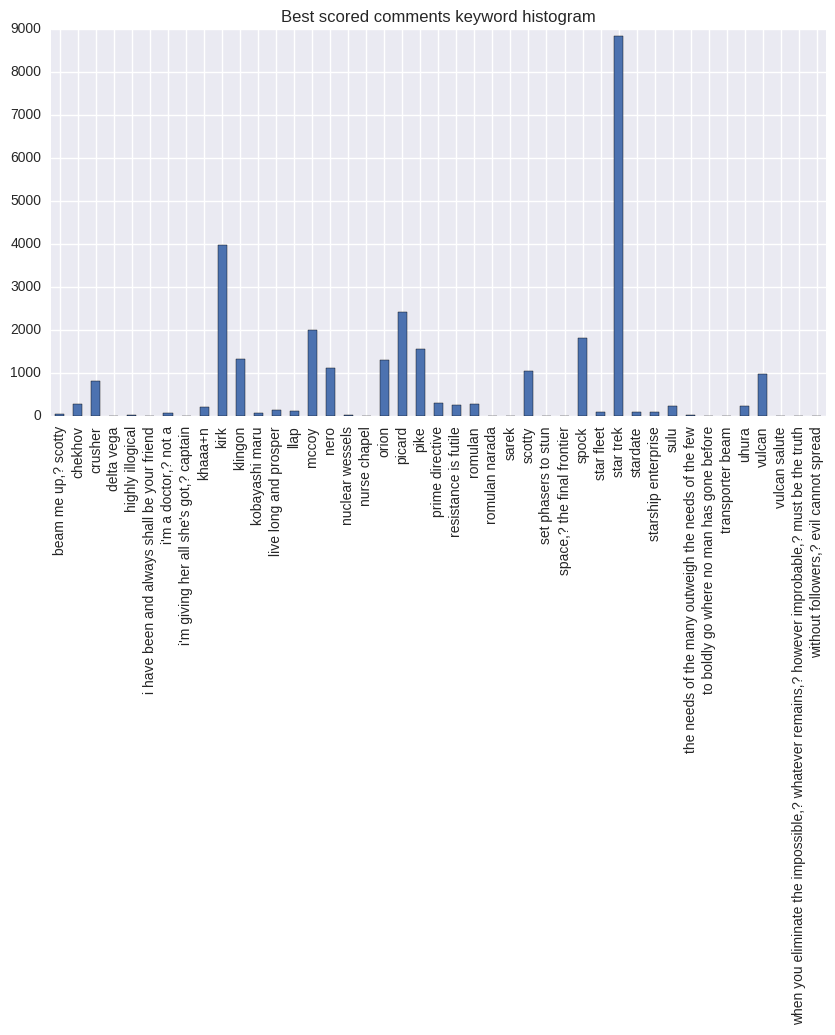

In [23]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Best scored comments keyword histogram',
)

### Bottom

In [24]:
bottom_scored = reddit_df.sort_values(['score'], ascending=True)[:len(reddit_df) * P // 100]

In [25]:
len(bottom_scored)

26698

In [26]:
bottom_scored.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
2355490,candyman420,"&gt; who knows, maybe this will even attract s...",0,2016-03-29 21:33:47,0,0,0,d1iir42,0,t1_d1id4ps,-478,startrek,-478,2016-03-01,2016-01-01
1306450,K4S3-R,"okay, this one legitimately made me laugh my a...",0,2014-09-21 16:32:35,0,0.0,0,ckop2ps,t1_ckop2ps,t1_ckooi1r,-472,AdviceAnimals,-472,2014-09-01,2014-01-01
2189904,Trentsexual,came here to downvote the first dumb and dumbe...,0,2016-01-01 20:28:23,0,0,0,cyiu3g4,0,t1_cyitxud,-442,AdviceAnimals,-442,2016-01-01,2016-01-01
1772147,Redskinsthebestskins,"dude let it go. - - we get it, eagles fans h...",0,2015-05-30 06:57:12,0,0.0,0,crpsmrl,t1_crpsmrl,t1_crpsl7d,-422,nfl,-422,2015-05-01,2015-01-01
2015006,guccigoogle,yoda is not from star trek my good sir. downvo...,0,2015-10-10 23:53:04,0,0,0,cvvhobs,0,t1_cvvfnqh,-263,funny,-263,2015-10-01,2015-01-01


In [27]:
bottom_scored.ix[2355490]['body']

"&gt; who knows, maybe this will even attract some new fans! -  - it probably won't, or not very many.  star trek is mostly for nerds. -  - edit:  that's where all of you came from, #1 post in subreddit drama!  have fun! -  - up to -91 now.  i am sure each and every one of you are following the rules to the letter. -  - let's make it a game, see if you can bring my karma below 15,000.  ready set, go! - -- - i couldn't have done it without you guys!  up to -314 now.  i'm afraid you failed the mission though.  total karma is now still at 15,107.  better luck next time."

#### Temporal evolution

In [28]:
df_by_month = pd.Series(bottom_scored.groupby('month')['id'].count())
df_by_month.index.name = None

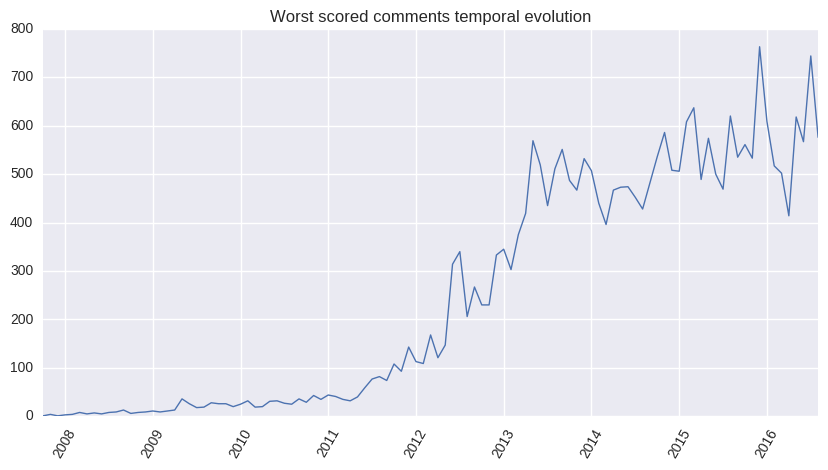

In [29]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=valid_dates,
    rot=60,
    title='Worst scored comments temporal evolution',
)
# ax.set_xticklabels(show_dates);

#### Histogram

In [30]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = bottom_scored['body'].str.count(k).sum()

CPU times: user 1.76 s, sys: 179 µs, total: 1.76 s
Wall time: 1.76 s


In [31]:
keywords_counter = Counter(keywords_dict)

In [32]:
keywords_counter.most_common()

[('star trek', 8339),
 ('kirk', 2454),
 ('mccoy', 2429),
 ('vulcan', 1655),
 ('orion', 1469),
 ('pike', 1414),
 ('spock', 1169),
 ('picard', 1096),
 ('nero', 794),
 ('crusher', 721),
 ('klingon', 639),
 ('scotty', 597),
 ('resistance is futile', 579),
 ('sulu', 257),
 ('prime directive', 201),
 ('romulan', 155),
 ('live long and prosper', 136),
 ('uhura', 121),
 ('chekhov', 97),
 ('the needs of the many outweigh the needs of the few', 96),
 ('highly illogical', 87),
 ('star fleet', 83),
 ('khaaa+n', 51),
 ('starship enterprise', 48),
 ('llap', 43),
 ('beam me up,? scotty', 31),
 ('kobayashi maru', 24),
 ('vulcan salute', 11),
 ('stardate', 10),
 ('sarek', 7),
 ("i'm a doctor,? not a", 6),
 ('to boldly go where no man has gone before', 4),
 ('delta vega', 3),
 ('space,? the final frontier', 3),
 ('nurse chapel', 2),
 ('transporter beam', 2),
 ('nuclear wessels', 2),
 ('i have been and always shall be your friend', 1),
 ('when you eliminate the impossible,? whatever remains,? however imp

In [33]:
keywords_sr = pd.Series(keywords_dict)

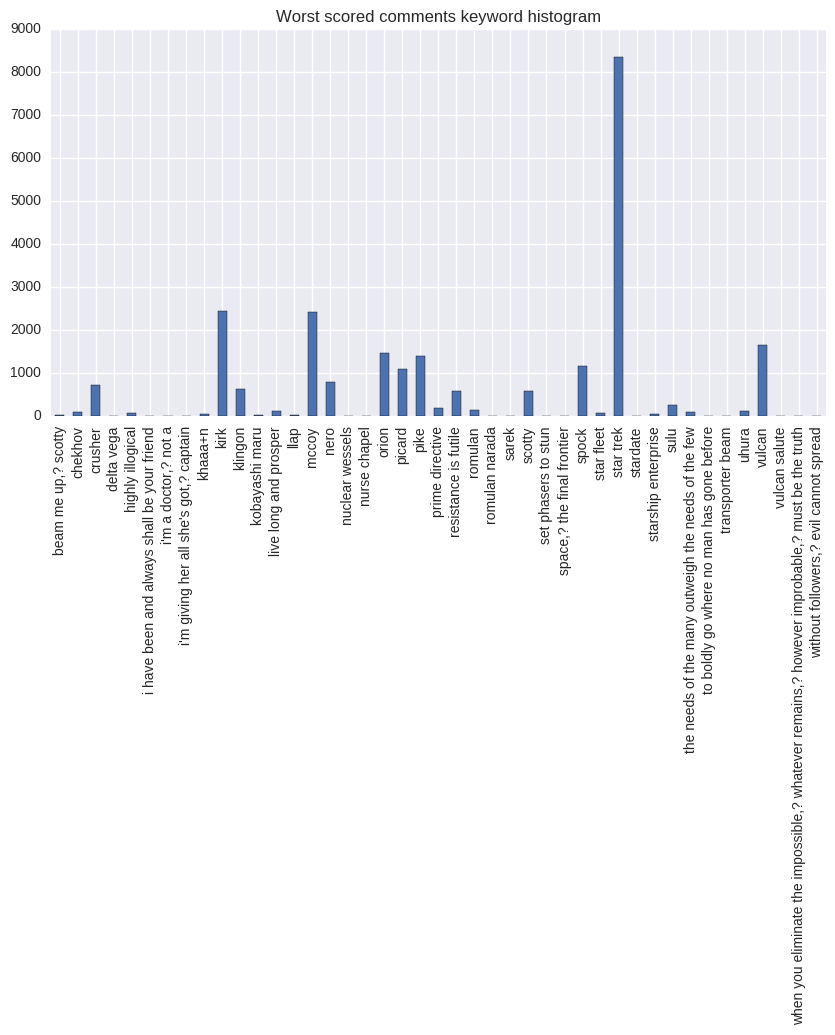

In [34]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Worst scored comments keyword histogram',
)

## Controversiality

In [35]:
controversial_df = reddit_df[reddit_df['controversiality'] == 1]

In [36]:
len(controversial_df)

28894

In [37]:
len(reddit_df)

2669814

In [38]:
print('%.2f' % (100 * len(controversial_df) / len(reddit_df)) + '%')

1.08%


In [39]:
P = 10

### Global

In [40]:
SHOW = 100

In [41]:
show_aux = 20

#### Temporal evolution

In [42]:
valid_dates = pd.date_range('2007-10-1', '2016-08-31', freq='MS')

peaks = ['2012-01-01', '2013-03-01', '2014-01-01', '2014-05-01', '2015-05-01', '2015-08-01', '2015-12-01', '2016-07-01',]
peaks = list(map(pd.lib.Timestamp, peaks))

show_dates = [x.strftime('%Y %b') if x in peaks else '' for x in valid_dates]

In [43]:
df_by_month = pd.Series(controversial_df.groupby('month')['id'].count())
df_by_month.index.name = None

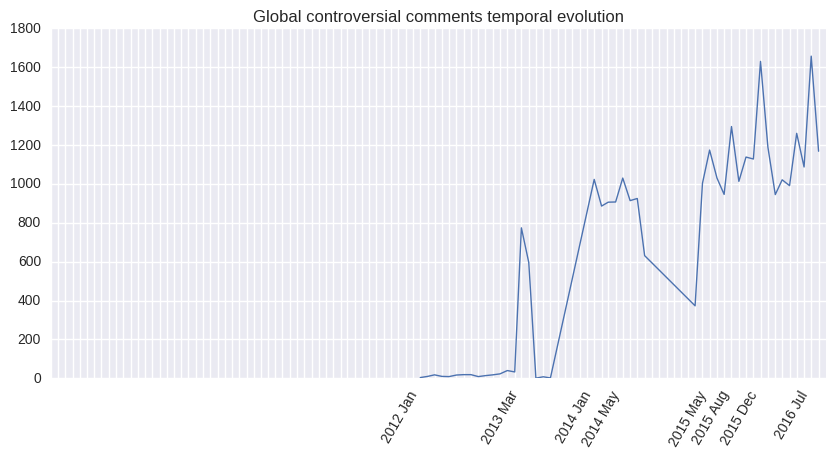

In [44]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=valid_dates,
    rot=60,
    title='Global controversial comments temporal evolution',
)
ax.set_xticklabels(show_dates);

#### Histogram

In [45]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = controversial_df['body'].str.count(k).sum()

CPU times: user 1.92 s, sys: 0 ns, total: 1.92 s
Wall time: 1.92 s


In [46]:
keywords_counter = Counter(keywords_dict)

In [47]:
keywords_counter.most_common()

[('star trek', 10435),
 ('kirk', 3507),
 ('orion', 2745),
 ('mccoy', 2236),
 ('pike', 1697),
 ('vulcan', 1673),
 ('spock', 1216),
 ('picard', 1151),
 ('nero', 1030),
 ('klingon', 816),
 ('scotty', 770),
 ('crusher', 752),
 ('sulu', 420),
 ('romulan', 333),
 ('prime directive', 248),
 ('resistance is futile', 235),
 ('uhura', 183),
 ('chekhov', 151),
 ('the needs of the many outweigh the needs of the few', 94),
 ('live long and prosper', 83),
 ('star fleet', 74),
 ('llap', 70),
 ('highly illogical', 64),
 ('starship enterprise', 43),
 ('kobayashi maru', 37),
 ('khaaa+n', 35),
 ('beam me up,? scotty', 34),
 ('stardate', 8),
 ("i'm a doctor,? not a", 8),
 ('to boldly go where no man has gone before', 8),
 ('transporter beam', 6),
 ('delta vega', 5),
 ('nuclear wessels', 5),
 ('sarek', 5),
 ('set phasers to stun', 4),
 ('vulcan salute', 3),
 ('space,? the final frontier', 3),
 ('nurse chapel', 2),
 ("i'm giving her all she's got,? captain", 2),
 ('without followers,? evil cannot spread', 0

In [48]:
keywords_sr = pd.Series(keywords_dict)

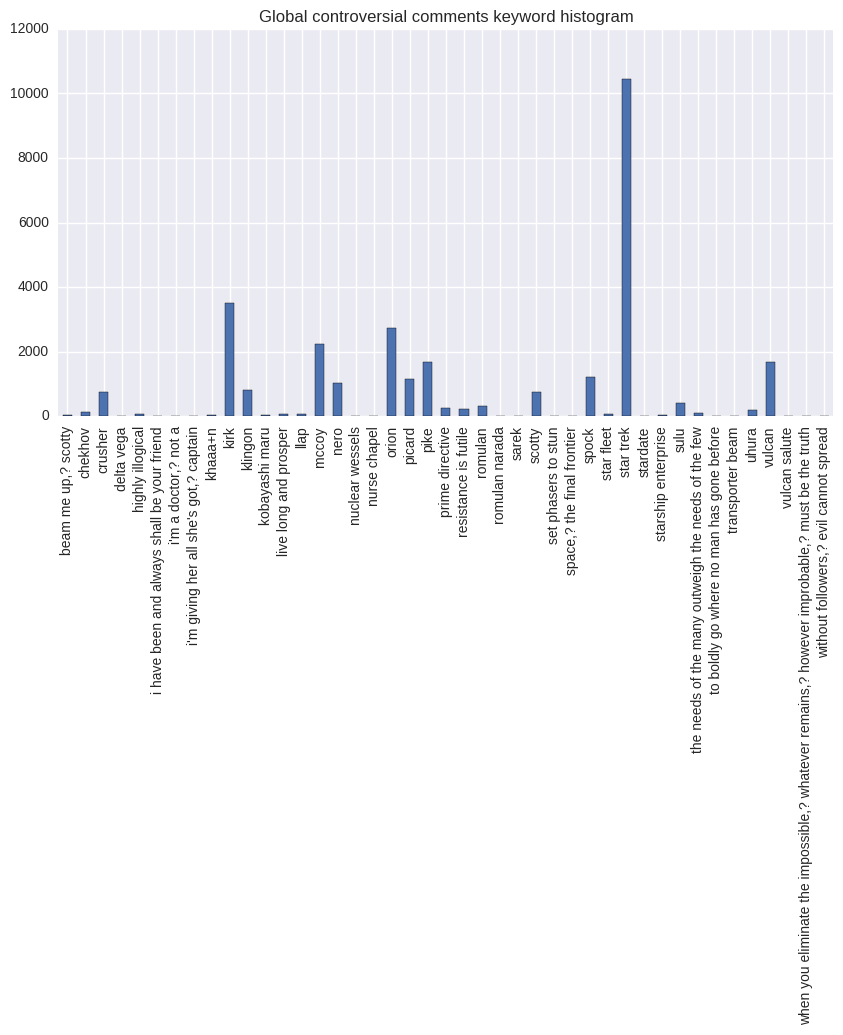

In [49]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Global controversial comments keyword histogram',
)

#### Peaks

In [50]:
peaks

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2013-03-01

In [51]:
date = '2013-03-01'

In [52]:
controversial_date_df = controversial_df[controversial_df['month'] == date]

In [53]:
len(controversial_date_df)

774

#### Histogram

###### Keywords

In [54]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = controversial_date_df[controversial_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [55]:
keywords_counter = Counter(keywords_dict)

In [56]:
keywords_counter.most_common()

[('star trek', 312),
 ('kirk', 83),
 ('picard', 55),
 ('mccoy', 32),
 ('vulcan', 32),
 ('spock', 26),
 ('klingon', 24),
 ('pike', 23),
 ('nero', 22),
 ('crusher', 21),
 ('romulan', 21),
 ('scotty', 21),
 ('sulu', 18),
 ('orion', 17),
 ('resistance is futile', 8),
 ('live long and prosper', 4),
 ('star fleet', 4),
 ('uhura', 2),
 ('the needs of the many outweigh the needs of the few', 2),
 ('chekhov', 2),
 ('khaaa+n', 2),
 ('beam me up,? scotty', 1),
 ('highly illogical', 1),
 ('prime directive', 1),
 ('kobayashi maru', 1),
 ('to boldly go where no man has gone before', 1),
 ('starship enterprise', 1),
 ('sarek', 1),
 ('set phasers to stun', 0),
 ('stardate', 0),
 ('delta vega', 0),
 ('vulcan salute', 0),
 ('nurse chapel', 0),
 ('space,? the final frontier', 0),
 ('without followers,? evil cannot spread', 0),
 ('romulan narada', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('transporter beam', 0),
 ("i'm a doctor,? not a", 0),
 ('nuclear wessels', 0),
 ('llap', 0),
 ('i have bee

In [57]:
keywords_sr = pd.Series(keywords_dict)

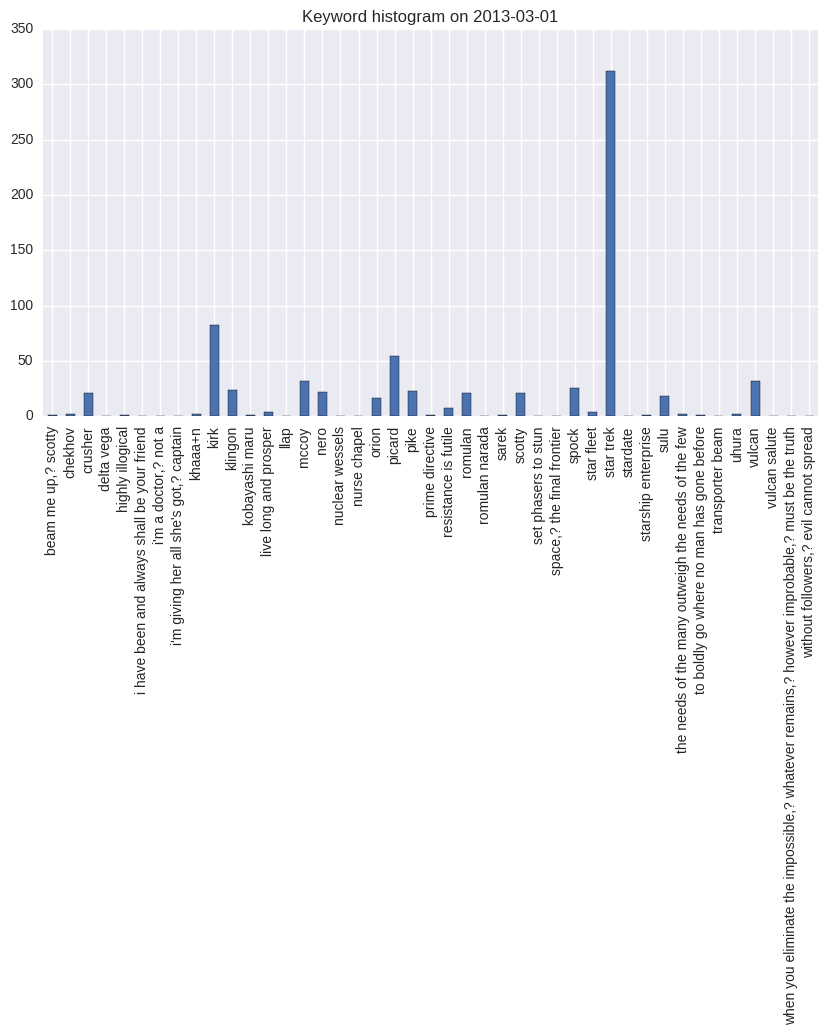

In [58]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [59]:
%%time

text_ = ''
for x in controversial_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 6.43 s, sys: 374 ms, total: 6.8 s
Wall time: 6.81 s


In [60]:
counter_.most_common(SHOW)

[("n't", 587),
 ('star', 342),
 ('trek', 317),
 ('like', 249),
 ('http', 232),
 ('people', 217),
 ('...', 163),
 ('would', 160),
 ('get', 150),
 ('think', 140),
 ("'re", 135),
 ('one', 133),
 ('even', 115),
 ('really', 112),
 ('time', 104),
 ('know', 104),
 ('good', 100),
 ('much', 95),
 ('going', 90),
 ('first', 88),
 ('see', 85),
 ('want', 84),
 ('well', 84),
 ('give', 82),
 ('kirk', 79),
 ('make', 76),
 ('way', 70),
 ('many', 69),
 ('right', 68),
 ('ago', 68),
 ('movie', 68),
 ('actually', 67),
 ('also', 65),
 ('show', 65),
 ('point', 64),
 ('lot', 64),
 ('better', 64),
 ('still', 64),
 ('hours', 63),
 ('report', 63),
 ('game', 63),
 ('new', 62),
 ('points', 60),
 ('say', 59),
 ('could', 58),
 ('reply', 58),
 ('fuck', 57),
 ('things', 57),
 ('made', 56),
 ('got', 56),
 ('gold', 55),
 ('permalink', 55),
 ('never', 53),
 ('thing', 52),
 ('fucking', 52),
 ("'ve", 52),
 ('something', 52),
 ('shit', 52),
 ('bad', 51),
 ('games', 50),
 ('probably', 50),
 ('two', 50),
 ("'ll", 47),
 ('said

###### n-grams

In [61]:
list_ = nltk.word_tokenize(text_)

In [62]:
counter_aux = Counter(dict(counter_.most_common(show_aux)))

###### 2-grams

In [63]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (2, 2))
    if any(map(lambda x: x in counter_aux, ng))
]

In [64]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [65]:
other_word_ngrams_counter.most_common(SHOW)

[(('star', 'trek'), 296),
 (('http', ':'), 232),
 (('(', 'http'), 221),
 (('do', "n't"), 216),
 (('you', "'re"), 74),
 (('does', "n't"), 70),
 (('ca', "n't"), 66),
 (('going', 'to'), 60),
 (('i', 'think'), 57),
 (('is', "n't"), 56),
 (('did', "n't"), 50),
 (('the', 'first'), 45),
 (('they', "'re"), 39),
 (('to', 'get'), 39),
 (('trek', '.'), 36),
 (('star', 'wars'), 33),
 (('trek', ','), 31),
 (("n't", 'have'), 29),
 (('i', 'know'), 28),
 (('i', 'would'), 27),
 (('was', "n't"), 26),
 (("n't", 'know'), 25),
 (('like', 'a'), 25),
 (('are', "n't"), 24),
 (('the', 'star'), 24),
 (("n't", 'think'), 24),
 (('time', '.'), 23),
 (('think', 'that'), 23),
 (('one', 'of'), 22),
 (('would', 'be'), 22),
 (("n't", 'like'), 22),
 (('we', "'re"), 22),
 (('of', 'star'), 20),
 (('people', 'who'), 19),
 (('like', 'the'), 19),
 (('...', '-'), 19),
 (("n't", 'even'), 19),
 (('the', 'time'), 19),
 (('would', 'have'), 19),
 (('.', 'star'), 18),
 (('would', "n't"), 18),
 (("n't", 'be'), 18),
 (('a', 'star'), 

###### 3-grams

In [66]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (3, 3))
    if any(map(lambda x: x in counter_aux, ng))
]

In [67]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [68]:
other_word_ngrams_counter.most_common(SHOW)

[(('(', 'http', ':'), 221),
 ((']', '(', 'http'), 219),
 (('i', 'do', "n't"), 72),
 (('http', ':', '//www.youtube.com/watch'), 40),
 (('star', 'trek', '.'), 33),
 (('star', 'trek', ','), 30),
 (('you', 'ca', "n't"), 30),
 (('do', "n't", 'know'), 20),
 (('you', 'do', "n't"), 20),
 (('...', '-', '-'), 19),
 (('they', 'do', "n't"), 19),
 (('of', 'star', 'trek'), 19),
 (('do', "n't", 'think'), 19),
 (('the', 'star', 'trek'), 17),
 (('http', ':', '//www.reddit.com/r/qkme_transcriber/'), 16),
 (('http',
   ':',
   '//www.reddit.com/r/qkme_transcriber/comments/o426k/faq_for_the_qkme_transcriber_bot/'),
  16),
 (("n't", 'reach', 'it'), 16),
 (('http',
   ':',
   '//www.reddit.com/r/internetama/comments/12gog9/i_am_the_creator_of_qkme_transcriber_a_definitely/'),
  16),
 (('http',
   ':',
   '//www.reddit.com/r/self/comments/vxeak/hello_i_am_a_bot_who_posts_transcriptions_of/'),
  16),
 (('ca', "n't", 'reach'), 16),
 (('http', ':', '//translate.google.com/'), 16),
 (('do', "n't", 'like'), 15),


#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [69]:
%%time

sentiment_list = []
for x in controversial_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 630 ms, sys: 152 µs, total: 631 ms
Wall time: 629 ms


In [70]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [71]:
sentiment_df.head()

,body,sentiment,subjectivity
0,it isn't which is my point. you're bashing ame...,0.04,0.68
1,grow up,0.00,0.00
2,yeah they don't fear the bottom four teams. be...,0.00,0.00
3,**annoyed picard** - - - - &gt; - why the f...,-0.40,0.70
4,i alway think gios look like set dec from the ...,0.00,0.00


In [72]:
sentiment_df['sentiment'].mean()

0.058143194790906884

In [73]:
sentiment_df['subjectivity'].mean()

0.43170969917847701

##### Histogram top positive

In [74]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(controversial_date_df) * P // 100]

In [75]:
top_df

,body,sentiment,subjectivity
304,happy pike day!,1.00,1.00
723,i was born with perfect teeth. i'll be leaving...,1.00,1.00
433,"lol, your logic is flawless, spock.",0.90,0.85
520,lol. dat patience.,0.80,0.70
504,yeah i just... this looks nothing like star tr...,0.80,0.75
144,"yes, we would almost certainly elect hitler. i...",0.80,0.90
398,"flux pavilion is great. also doctor p, excisio...",0.80,0.75
177,hopefully star wars will prove so taxing he'll...,0.80,1.00
249,great costumes. cute figures. star trek. win. ...,0.74,0.59
468,"if this is what's to become of star trek, i'd ...",0.70,0.60


In [76]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 242 ms, sys: 20.2 ms, total: 262 ms
Wall time: 262 ms


In [77]:
top_counter = Counter(top_list)

In [78]:
top_counter.most_common(SHOW)

[('star', 29),
 ('trek', 24),
 ("n't", 17),
 ('would', 14),
 ('http', 12),
 ('like', 11),
 ('better', 10),
 ('good', 10),
 ('well', 8),
 ('...', 8),
 ('think', 7),
 ('get', 7),
 ('series', 7),
 ('see', 6),
 ('picard', 6),
 ('really', 6),
 ('great', 6),
 ('spock', 5),
 ('need', 5),
 ('awesome', 5),
 ('could', 5),
 ("'ll", 5),
 ('say', 5),
 ('win', 5),
 ('one', 5),
 ('sure', 5),
 ('scotty', 5),
 ('please', 4),
 ('time', 4),
 ('reddit', 4),
 ('show', 4),
 ('people', 4),
 ('wars', 4),
 ('best', 4),
 ('amp', 4),
 ('nero', 4),
 ('let', 4),
 ('science', 4),
 ('kirk', 4),
 ("'re", 4),
 ('much', 4),
 ('lol', 3),
 ('superior', 3),
 ('needed', 3),
 ('guitar', 3),
 ('someone', 3),
 ('ok.', 3),
 ('fine', 3),
 ('mccoy', 3),
 ('nice', 3),
 ('clg', 3),
 ('yeah', 3),
 ('original', 3),
 ('canon', 3),
 ('space', 3),
 ('row', 3),
 ('got', 3),
 ('almost', 3),
 ('federation', 3),
 ('bit', 3),
 ('free', 3),
 ('vulcan', 3),
 ('look', 3),
 ('fiction', 3),
 ('way', 3),
 ('happy', 3),
 ('edit', 3),
 ('faq', 3),


##### Histogram top negative

In [79]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(controversial_date_df) * P // 100]

In [80]:
top_df

,body,sentiment,subjectivity
19,it's all the klingon players. stupid feds and ...,-1.00,1.00
561,i hate every star trek and every star wars. wh...,-0.80,0.90
390,"""i'm an annoying douchebag."" - kirk cameron",-0.80,0.90
591,who doesn't use whiteboards these days? - - v...,-0.80,1.00
370,"you're so fucking stupid sometimes fox, it hur...",-0.80,1.00
261,i so want me a dr. crusher. :(,-0.75,1.00
675,i'm already sick of folks claiming kirk tackle...,-0.71,0.86
46,"no, he'd be mercilessly ripped on indefinitely.",-0.70,1.00
298,almost as bad as star trek: renegade,-0.70,0.67
320,you're almost as bad as the parents that buy t...,-0.70,0.67


In [81]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 328 ms, sys: 16 ms, total: 344 ms
Wall time: 344 ms


In [82]:
top_counter = Counter(top_list)

In [83]:
top_counter.most_common(SHOW)

[('http', 62),
 ("n't", 39),
 ('fuck', 21),
 ('star', 15),
 ('bad', 14),
 ('people', 14),
 ('trek', 13),
 ('...', 12),
 ("'re", 11),
 ('site', 10),
 ('bot', 9),
 ('would', 9),
 ('like', 9),
 ('meme', 9),
 ('reach', 8),
 ('goes', 8),
 ('background', 8),
 ('see', 8),
 ('//www.reddit.com/r/internetama/comments/12gog9/i_am_the_creator_of_qkme_transcriber_a_definitely/',
  8),
 ('direct', 8),
 ('picard', 8),
 ('image', 8),
 ('case', 8),
 ('//www.reddit.com/r/qkme_transcriber/comments/o426k/faq_for_the_qkme_transcriber_bot/',
  8),
 ('translate', 8),
 ('title', 8),
 ('info', 8),
 ('quickmeme', 8),
 ('//www.reddit.com/r/qkme_transcriber/', 8),
 ('//www.reddit.com/r/self/comments/vxeak/hello_i_am_a_bot_who_posts_transcriptions_of/',
  8),
 ('ama', 8),
 ('annoyed', 8),
 ('human', 8),
 ('says', 8),
 ('**why', 8),
 ('//translate.google.com/', 8),
 ('linked', 8),
 ('make', 7),
 ('one', 7),
 ('anyone', 7),
 ('shit', 7),
 ('example', 6),
 ('want', 6),
 ('know', 6),
 ('game', 6),
 ('stupid', 5),
 ('e

In [84]:
peaks

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2014-01-01

In [85]:
date = '2014-01-01'

In [86]:
controversial_date_df = controversial_df[controversial_df['month'] == date]

In [87]:
len(controversial_date_df)

1023

#### Histogram

###### Keywords

In [88]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = controversial_date_df[controversial_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [89]:
keywords_counter = Counter(keywords_dict)

In [90]:
keywords_counter.most_common()

[('star trek', 280),
 ('orion', 84),
 ('vulcan', 73),
 ('kirk', 69),
 ('picard', 65),
 ('mccoy', 62),
 ('pike', 49),
 ('spock', 32),
 ('klingon', 26),
 ('nero', 23),
 ('scotty', 21),
 ('crusher', 17),
 ('uhura', 12),
 ('prime directive', 9),
 ('the needs of the many outweigh the needs of the few', 7),
 ('resistance is futile', 7),
 ('romulan', 6),
 ('highly illogical', 5),
 ('beam me up,? scotty', 4),
 ('sulu', 4),
 ('khaaa+n', 4),
 ('chekhov', 3),
 ('live long and prosper', 3),
 ('starship enterprise', 2),
 ('vulcan salute', 1),
 ('llap', 1),
 ('set phasers to stun', 0),
 ('stardate', 0),
 ('delta vega', 0),
 ('nurse chapel', 0),
 ('space,? the final frontier', 0),
 ('without followers,? evil cannot spread', 0),
 ('romulan narada', 0),
 ('star fleet', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('transporter beam', 0),
 ('kobayashi maru', 0),
 ("i'm a doctor,? not a", 0),
 ('to boldly go where no man has gone before', 0),
 ('nuclear wessels', 0),
 ('i have been and always sha

In [91]:
keywords_sr = pd.Series(keywords_dict)

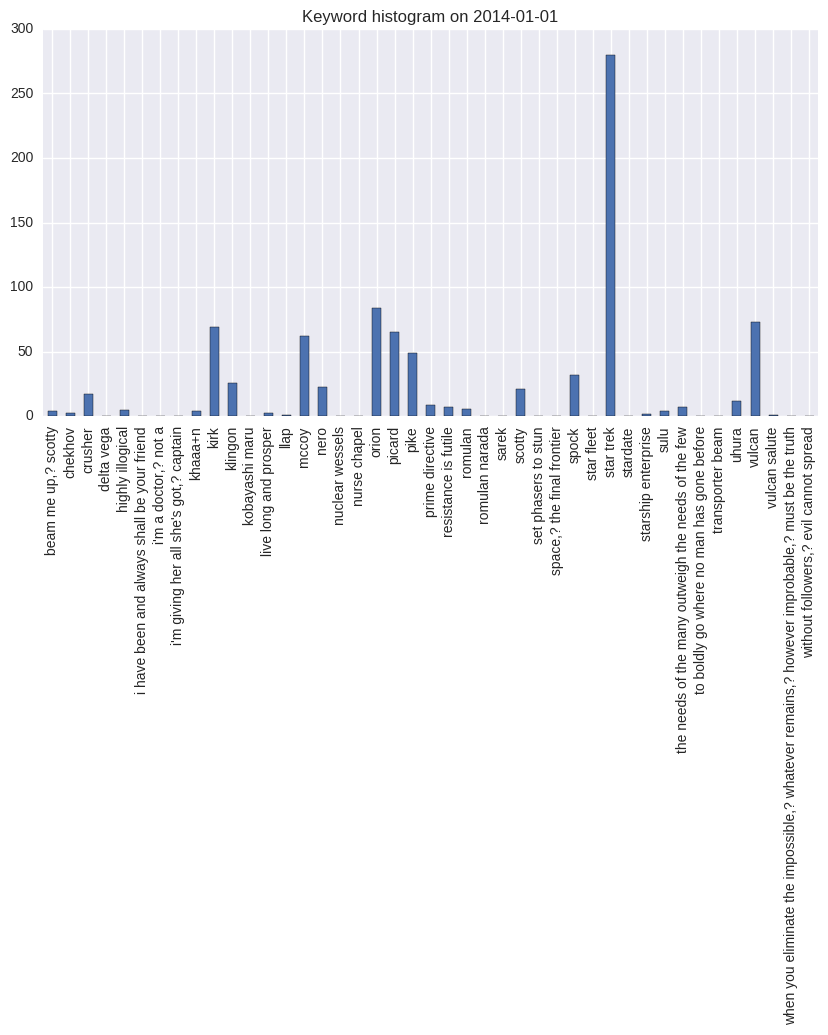

In [92]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [93]:
%%time

text_ = ''
for x in controversial_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 9.51 s, sys: 590 ms, total: 10.1 s
Wall time: 10.1 s


In [94]:
counter_.most_common(SHOW)

[("n't", 695),
 ('like', 360),
 ('star', 319),
 ('trek', 305),
 ('would', 292),
 ('people', 241),
 ('one', 213),
 ('think', 212),
 ('...', 188),
 ('get', 165),
 ('could', 149),
 ("'re", 136),
 ('even', 135),
 ('time', 133),
 ('really', 132),
 ('also', 128),
 ('know', 128),
 ('good', 126),
 ('much', 124),
 ('still', 123),
 ("'ve", 118),
 ('http', 115),
 ('game', 107),
 ('see', 105),
 ('want', 105),
 ('make', 101),
 ('well', 100),
 ('first', 96),
 ('years', 95),
 ('better', 93),
 ('way', 90),
 ('say', 89),
 ('going', 88),
 ('amp', 86),
 ('actually', 82),
 ('never', 80),
 ('orion', 78),
 ('got', 78),
 ('right', 76),
 ('something', 76),
 ('point', 75),
 ('many', 73),
 ('said', 73),
 ('every', 73),
 ('made', 71),
 ('things', 71),
 ('movies', 70),
 ('back', 69),
 ('vulcan', 68),
 ('bad', 67),
 ('take', 67),
 ('new', 65),
 ('best', 64),
 ('lot', 64),
 ('great', 64),
 ('thing', 63),
 ('movie', 63),
 ('kirk', 62),
 ('mccoy', 61),
 ('look', 60),
 ('world', 59),
 ('another', 58),
 ('though', 58),

###### n-grams

In [95]:
list_ = nltk.word_tokenize(text_)

In [96]:
counter_aux = Counter(dict(counter_.most_common(show_aux)))

###### 2-grams

In [97]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (2, 2))
    if any(map(lambda x: x in counter_aux, ng))
]

In [98]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [99]:
other_word_ngrams_counter.most_common(SHOW)

[(('star', 'trek'), 273),
 (('do', "n't"), 246),
 (('you', "'re"), 82),
 (('does', "n't"), 80),
 (('i', 'think'), 78),
 (('did', "n't"), 74),
 (('ca', "n't"), 62),
 (('is', "n't"), 58),
 (('would', 'be'), 54),
 (('one', 'of'), 52),
 (('to', 'get'), 46),
 (('i', 'would'), 42),
 (('star', 'wars'), 41),
 (('would', 'have'), 40),
 (("n't", 'know'), 38),
 (('you', 'think'), 38),
 (('you', 'could'), 38),
 (("n't", 'have'), 37),
 (('i', 'know'), 36),
 (("n't", 'want'), 36),
 (('like', 'a'), 33),
 (('a', 'good'), 32),
 (('they', "'re"), 30),
 (('trek', '.'), 30),
 (('people', 'who'), 29),
 (('would', "n't"), 28),
 (('trek', ','), 28),
 (('like', 'the'), 28),
 (('are', "n't"), 27),
 (('have', "n't"), 27),
 (('would', 'you'), 27),
 (('think', 'that'), 26),
 (('...', '-'), 26),
 (('a', 'star'), 25),
 (('think', 'it'), 25),
 (("n't", 'think'), 24),
 (('time', '.'), 23),
 (('you', 'know'), 22),
 ((',', 'would'), 22),
 (('we', "'re"), 22),
 (('so', 'much'), 22),
 (("n't", 'even'), 21),
 (('the', 'st

###### 3-grams

In [100]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (3, 3))
    if any(map(lambda x: x in counter_aux, ng))
]

In [101]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [102]:
other_word_ngrams_counter.most_common(SHOW)

[(('i', 'do', "n't"), 103),
 (('do', "n't", 'know'), 31),
 (('star', 'trek', '.'), 28),
 (('star', 'trek', ','), 28),
 (('one', 'of', 'the'), 27),
 (('you', 'do', "n't"), 26),
 (("n't", 'want', 'to'), 24),
 (('.', 'i', 'think'), 24),
 (('do', "n't", 'think'), 24),
 (('...', '-', '-'), 23),
 (('i', 'ca', "n't"), 23),
 (('i', 'did', "n't"), 22),
 (('do', "n't", 'want'), 22),
 (('do', "n't", 'have'), 20),
 (('of', 'star', 'trek'), 19),
 (('a', 'star', 'trek'), 18),
 (('it', 'does', "n't"), 17),
 (('if', 'you', 'could'), 17),
 (('the', 'star', 'trek'), 17),
 ((',', 'would', 'you'), 16),
 (('.', 'you', "'re"), 16),
 (('do', "n't", 'like'), 15),
 (('think', 'it', "'s"), 15),
 (('.', 'star', 'trek'), 14),
 (('they', 'do', "n't"), 14),
 (('star', 'trek', 'movies'), 14),
 (('i', 'have', "n't"), 13),
 (('you', 'ca', "n't"), 13),
 (('would', 'you', '?'), 13),
 (('you', 'think', 'of'), 12),
 (('i', 'think', 'it'), 12),
 (('.', 'i', 'would'), 12),
 (('-', '-', 'also'), 11),
 (('do', 'you', 'think')

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [103]:
%%time

sentiment_list = []
for x in controversial_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 776 ms, sys: 3.9 ms, total: 780 ms
Wall time: 779 ms


In [104]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [105]:
sentiment_df.head()

,body,sentiment,subjectivity
0,hence why it was removed as a default subreddi...,-0.10,0.13
1,who do you think is a better candidate? mccoy ...,0.50,0.50
2,"he didn't build it. read your own article, at ...",0.45,0.86
3,shady mccoy no doubt,-0.25,0.62
4,anything from 40k would curb stomp anything fr...,-0.22,0.56


In [106]:
sentiment_df['sentiment'].mean()

0.059881490490876155

In [107]:
sentiment_df['subjectivity'].mean()

0.44335336689689009

##### Histogram top positive

In [108]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(controversial_date_df) * P // 100]

In [109]:
top_df

,body,sentiment,subjectivity
348,generations is the best star trek film.,1.00,0.30
525,this is fucking awesome.,1.00,1.00
907,"i'll bet she is an awesome rock, paper, scisso...",1.00,1.00
825,happy cake day to you from another!,1.00,1.00
133,you magnificent bastards,1.00,1.00
250,sounds like an awesome mom!,1.00,1.00
918,"in all fairness, best sex ive ever had",1.00,0.30
399,star trek into darkness got great reviews. tho...,0.80,0.75
930,lol,0.80,0.70
588,star trek online is overrun with pay to win el...,0.80,0.40


In [110]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 336 ms, sys: 11.9 ms, total: 348 ms
Wall time: 347 ms


In [111]:
top_counter = Counter(top_list)

In [112]:
top_counter.most_common(SHOW)

[('amp', 47),
 ("n't", 29),
 ('star', 28),
 ('trek', 24),
 ('would', 19),
 ('...', 19),
 ('better', 15),
 ('like', 15),
 ('think', 15),
 ('good', 13),
 ('best', 11),
 ('still', 10),
 ('one', 9),
 ('people', 9),
 ('got', 7),
 ('orion', 7),
 ('awesome', 6),
 ('even', 6),
 ("'re", 6),
 ('another', 6),
 ('kind', 5),
 ('look', 5),
 ('mccoy', 5),
 ('movies', 5),
 ('kirk', 5),
 ('everyone', 5),
 ('pretty', 5),
 ('know', 5),
 ('windows', 5),
 ('year', 5),
 ('spock', 4),
 ('able', 4),
 ('place', 4),
 ('see', 4),
 ('picard', 4),
 ('liked', 4),
 ('abrams', 4),
 ('sure', 4),
 ('spanking', 4),
 ('wars', 4),
 ('made', 4),
 ('god', 4),
 ('guy', 4),
 ('maybe', 4),
 ('great', 4),
 ('movie', 4),
 ('really', 4),
 ('always', 4),
 ("'ve", 4),
 ('much', 4),
 ('lol', 3),
 ('minimum', 3),
 ('kelly', 3),
 ('something', 3),
 ('around', 3),
 ('domination', 3),
 ('nice', 3),
 ('time', 3),
 ('worship', 3),
 ('tell', 3),
 ('without', 3),
 ('make', 3),
 ('wage', 3),
 ('want', 3),
 ('hit', 3),
 ('say', 3),
 ('free', 

##### Histogram top negative

In [113]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(controversial_date_df) * P // 100]

In [114]:
top_df

,body,sentiment,subjectivity
321,jj's star trek films were terrible *star trek*...,-1.00,1.00
591,hey its another moron complaining about orion!...,-1.00,1.00
898,mccoy fucked my mom!!!,-1.00,0.70
774,betty banks-burke ^a ^teacher ^i ^hated,-0.90,0.70
635,i'd say star trek 5 is the worst but generatio...,-0.85,0.83
193,you're an idiot.,-0.80,0.80
722,fucking retarded,-0.80,0.80
122,i'm so stupid -_- i didn't even know that you ...,-0.80,1.00
335,i did not accuse anyone of being weird for a (...,-0.75,1.00
65,no you didn't. stop lying. my uncle told me th...,-0.70,0.67


In [115]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 359 ms, sys: 19.9 ms, total: 378 ms
Wall time: 378 ms


In [116]:
top_counter = Counter(top_list)

In [117]:
top_counter.most_common(SHOW)

[("n't", 33),
 ('star', 21),
 ('fuck', 19),
 ('trek', 18),
 ('like', 17),
 ('...', 15),
 ('picard', 13),
 ('bad', 12),
 ('fucking', 11),
 ('even', 11),
 ('vulcan', 10),
 ('people', 10),
 ('see', 8),
 ("'re", 8),
 ('^^are', 8),
 ('hate', 7),
 ('would', 7),
 ('stupid', 7),
 ('think', 7),
 ('play', 7),
 ('game', 7),
 ('get', 7),
 ('stop', 6),
 ('http', 6),
 ('shit', 6),
 ('meme', 6),
 ('someone', 5),
 ('getting', 5),
 ('mccoy', 5),
 ('say', 5),
 ('kirk', 5),
 ('way', 5),
 ('**annoyed', 5),
 ('least', 5),
 ('child', 4),
 ('^^probably', 4),
 ('place', 4),
 ('^^directly', 4),
 ('something', 4),
 ('please', 4),
 ('worst', 4),
 ('^^servers', 4),
 ('1080p**', 4),
 ('terrible', 4),
 ('anything', 4),
 ('*^^these', 4),
 ('ridiculous', 4),
 ('want', 4),
 ('market', 4),
 ('sorry', 4),
 ('^^livememe', 4),
 ('women', 4),
 ('know', 4),
 ('everything', 4),
 ('face', 4),
 ('^^from', 4),
 ('agree', 4),
 ('^^captions', 4),
 ('^^correct*', 4),
 ('really', 4),
 ('microsoft', 4),
 ('spanking', 4),
 ('^^scrape

In [118]:
peaks

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2014-05-01

In [119]:
date = '2014-05-01'

In [120]:
controversial_date_df = controversial_df[controversial_df['month'] == date]

In [121]:
len(controversial_date_df)

1030

#### Histogram

###### Keywords

In [122]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = controversial_date_df[controversial_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [123]:
keywords_counter = Counter(keywords_dict)

In [124]:
keywords_counter.most_common()

[('star trek', 416),
 ('kirk', 105),
 ('orion', 86),
 ('mccoy', 76),
 ('pike', 59),
 ('picard', 51),
 ('klingon', 49),
 ('spock', 47),
 ('vulcan', 43),
 ('crusher', 26),
 ('scotty', 23),
 ('nero', 20),
 ('romulan', 15),
 ('prime directive', 8),
 ('resistance is futile', 7),
 ('uhura', 4),
 ('chekhov', 3),
 ('live long and prosper', 3),
 ('sulu', 3),
 ('llap', 3),
 ('beam me up,? scotty', 2),
 ('highly illogical', 2),
 ('kobayashi maru', 2),
 ('sarek', 2),
 ('set phasers to stun', 1),
 ('star fleet', 1),
 ('khaaa+n', 1),
 ('starship enterprise', 1),
 ('stardate', 0),
 ('delta vega', 0),
 ('vulcan salute', 0),
 ('nurse chapel', 0),
 ('the needs of the many outweigh the needs of the few', 0),
 ('space,? the final frontier', 0),
 ('without followers,? evil cannot spread', 0),
 ('romulan narada', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('transporter beam', 0),
 ("i'm a doctor,? not a", 0),
 ('to boldly go where no man has gone before', 0),
 ('nuclear wessels', 0),
 ('i have bee

In [125]:
keywords_sr = pd.Series(keywords_dict)

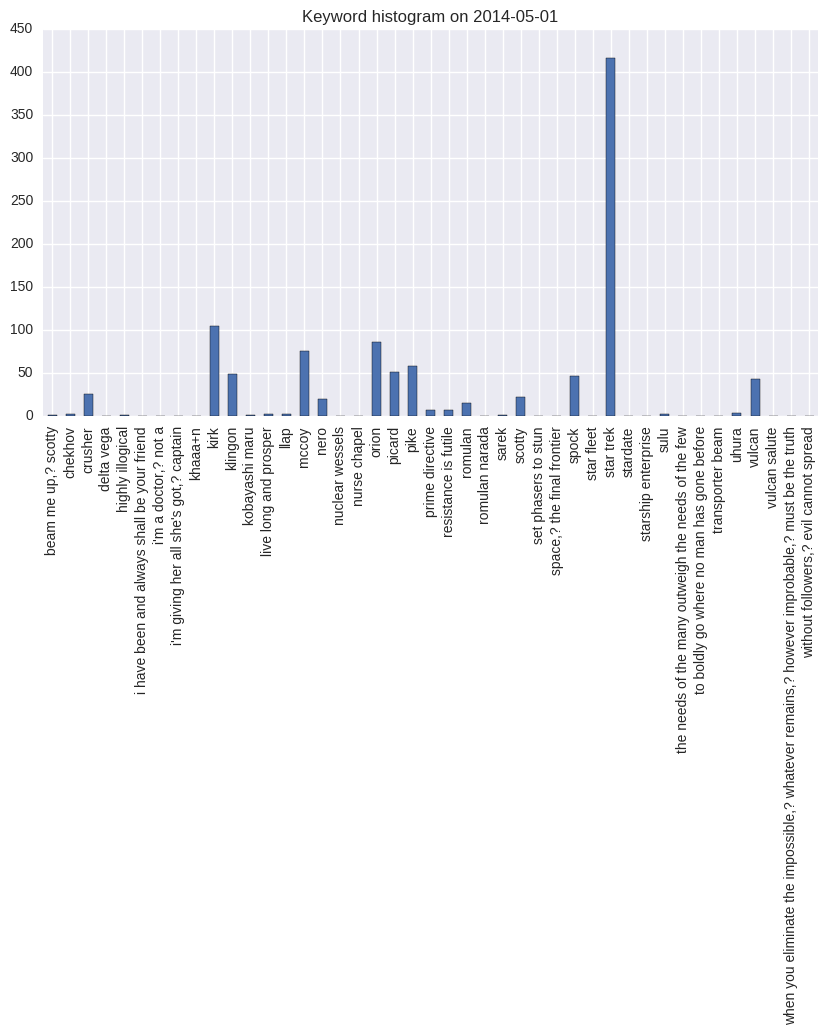

In [126]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [127]:
%%time

text_ = ''
for x in controversial_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 8.69 s, sys: 495 ms, total: 9.19 s
Wall time: 9.19 s


In [128]:
counter_.most_common(SHOW)

[("n't", 698),
 ('star', 457),
 ('trek', 455),
 ('like', 367),
 ('would', 317),
 ('people', 228),
 ('one', 206),
 ('...', 189),
 ('get', 184),
 ('think', 168),
 ("'re", 159),
 ('even', 155),
 ('time', 151),
 ('really', 143),
 ('good', 137),
 ('know', 136),
 ('make', 129),
 ('could', 127),
 ('much', 124),
 ('movie', 114),
 ('new', 114),
 ('see', 113),
 ('better', 113),
 ('way', 109),
 ('also', 109),
 ("'ve", 108),
 ('want', 107),
 ('kirk', 102),
 ('http', 101),
 ('movies', 98),
 ('well', 98),
 ('going', 97),
 ('still', 97),
 ('never', 92),
 ('right', 90),
 ('game', 87),
 ('say', 85),
 ('something', 82),
 ('first', 82),
 ('made', 79),
 ('orion', 79),
 ('bad', 75),
 ('mccoy', 74),
 ('back', 73),
 ('said', 73),
 ('take', 72),
 ('many', 70),
 ('look', 70),
 ('things', 67),
 ('around', 67),
 ('years', 66),
 ('actually', 66),
 ('work', 65),
 ('point', 65),
 ('series', 64),
 ('need', 64),
 ('got', 64),
 ("'ll", 63),
 ('khan', 63),
 ('shit', 62),
 ('every', 61),
 ('fuck', 60),
 ('best', 60),
 (

###### n-grams

In [129]:
list_ = nltk.word_tokenize(text_)

In [130]:
counter_aux = Counter(dict(counter_.most_common(show_aux)))

###### 2-grams

In [131]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (2, 2))
    if any(map(lambda x: x in counter_aux, ng))
]

In [132]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [133]:
other_word_ngrams_counter.most_common(SHOW)

[(('star', 'trek'), 404),
 (('do', "n't"), 221),
 (('you', "'re"), 88),
 (('does', "n't"), 84),
 (('did', "n't"), 81),
 (('i', 'think'), 77),
 (('is', "n't"), 67),
 (('would', 'be'), 65),
 (('ca', "n't"), 58),
 (('they', "'re"), 52),
 (('i', 'would'), 48),
 (('to', 'make'), 48),
 (('one', 'of'), 44),
 (('to', 'get'), 41),
 (("n't", 'have'), 41),
 (('trek', '.'), 41),
 (('star', 'wars'), 39),
 (('trek', ','), 38),
 (('like', 'the'), 36),
 (('it', 'would'), 35),
 (('would', "n't"), 33),
 (('the', 'time'), 33),
 (('would', 'have'), 32),
 (('you', 'know'), 31),
 (('was', "n't"), 30),
 (("n't", 'like'), 30),
 (('like', 'a'), 29),
 (('of', 'star'), 28),
 (('i', 'know'), 28),
 (('a', 'good'), 28),
 (('movie', '.'), 27),
 (('are', "n't"), 26),
 (('the', 'star'), 26),
 (('the', 'movie'), 25),
 (('make', 'it'), 25),
 (('trek', 'movies'), 24),
 (("n't", 'want'), 24),
 (('.', 'star'), 24),
 (('...', '-'), 23),
 (('people', 'who'), 23),
 (('of', 'people'), 22),
 (('i', 'could'), 22),
 (('wo', "n't"

###### 3-grams

In [134]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (3, 3))
    if any(map(lambda x: x in counter_aux, ng))
]

In [135]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [136]:
other_word_ngrams_counter.most_common(SHOW)

[(('i', 'do', "n't"), 76),
 (('star', 'trek', '.'), 37),
 (('star', 'trek', ','), 36),
 (('you', 'do', "n't"), 31),
 (('one', 'of', 'the'), 29),
 (('of', 'star', 'trek'), 27),
 (('the', 'star', 'trek'), 24),
 (('.', 'star', 'trek'), 22),
 (('...', '-', '-'), 21),
 (('.', 'i', 'think'), 21),
 (('if', 'you', "'re"), 20),
 (('do', "n't", 'like'), 19),
 (('star', 'trek', 'movies'), 19),
 (('it', 'would', 'be'), 18),
 (('do', "n't", 'know'), 17),
 (('they', 'do', "n't"), 17),
 (('it', 'does', "n't"), 17),
 (('star', 'trek', ':'), 17),
 (('star', 'trek', 'is'), 17),
 (('a', 'star', 'trek'), 17),
 (('i', 'did', "n't"), 16),
 (('it', 'was', "n't"), 16),
 (("n't", 'want', 'to'), 15),
 (('i', 'ca', "n't"), 15),
 (('.', 'i', 'would'), 15),
 (('do', "n't", 'want'), 14),
 (('do', "n't", 'have'), 14),
 (('.', 'do', "n't"), 14),
 (('``', 'star', 'trek'), 14),
 (('star', 'trek', 'and'), 13),
 (('from', 'star', 'trek'), 13),
 (('i', 'feel', 'like'), 13),
 (('star', 'trek', 'into'), 13),
 ((',', 'you', 

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [137]:
%%time

sentiment_list = []
for x in controversial_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 770 ms, sys: 21 µs, total: 770 ms
Wall time: 769 ms


In [138]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [139]:
sentiment_df.head()

,body,sentiment,subjectivity
0,no one claps or applauds or cheers at home lik...,-0.02,0.46
1,the new star trek timeline. &lt;3 abrams,0.14,0.45
2,it's called j.j. abrams is a douche and ruined...,0.27,0.58
3,patrick stewart isn't in this picture. - - ed...,-0.10,0.65
4,[that's the joke.](http://img.pandawhale.com/7...,0.00,0.00


In [140]:
sentiment_df['sentiment'].mean()

0.069964211901910475

In [141]:
sentiment_df['subjectivity'].mean()

0.45179276027855919

##### Histogram top positive

In [142]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(controversial_date_df) * P // 100]

In [143]:
top_df

,body,sentiment,subjectivity
553,not in the best star trek. which is of course ...,1.00,0.30
732,warrior tears = awesome - - i guess it wasn't...,1.00,1.00
728,star trek... awesome,1.00,1.00
379,"""they are just numbers why should you care pic...",1.00,1.00
314,ohhhhhhhhhhh samurai was in that chest? lol i ...,0.80,0.70
459,&gt;jonathan frakes. - - famed director of st...,0.80,0.75
39,lol :p,0.78,0.85
318,nice try netflix!,0.75,1.00
512,also the albert pike bit is said to be a hoax:...,0.70,0.60
962,now let's get lodge and kirk and we're good on...,0.70,0.60


In [144]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 364 ms, sys: 28 ms, total: 392 ms
Wall time: 391 ms


In [145]:
top_counter = Counter(top_list)

In [146]:
top_counter.most_common(SHOW)

[("n't", 38),
 ('star', 34),
 ('trek', 29),
 ('like', 16),
 ('good', 16),
 ('better', 13),
 ('people', 12),
 ('would', 11),
 ('non', 11),
 ('best', 11),
 ('see', 10),
 ('...', 10),
 ('mccoy', 8),
 ('picard', 8),
 ('movies', 8),
 ('sure', 8),
 ('time', 7),
 ('think', 7),
 ('thought', 7),
 ('know', 7),
 ('city', 7),
 ('probably', 7),
 ('around', 6),
 ('kirk', 6),
 ('che', 6),
 ('could', 6),
 ('many', 6),
 ('even', 6),
 ('said', 6),
 ('orion', 6),
 ("'re", 6),
 ('great', 6),
 ('guys', 6),
 ('much', 6),
 ('lol', 5),
 ('also', 5),
 ('place', 5),
 ('well', 5),
 ('make', 5),
 ('got', 5),
 ('want', 5),
 ('going', 5),
 ('free', 5),
 ('one', 5),
 ('pretty', 5),
 ('care', 5),
 ('http', 5),
 ('always', 5),
 ('year', 5),
 ('life', 5),
 ('get', 5),
 ('look', 4),
 ('able', 4),
 ('peterson', 4),
 ('crusher', 4),
 ('high', 4),
 ('say', 4),
 ('love', 4),
 ('way', 4),
 ('start', 4),
 ('something', 4),
 ('things', 4),
 ('più', 4),
 ('play', 4),
 ('captain', 4),
 ('needs', 4),
 ('work', 4),
 ('numbers', 3)

##### Histogram top negative

In [147]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(controversial_date_df) * P // 100]

In [148]:
top_df

,body,sentiment,subjectivity
254,star trek (2009) was the worst of the three st...,-1.00,1.00
562,the worst star trek film to date?,-1.00,1.00
695,"mila kunis in a star trek series? holy crap, s...",-0.80,0.80
734,grief in orion.,-0.80,0.20
201,if it would be unbearable then why would i wan...,-0.80,0.80
827,gorillas are from south america you retard. - ...,-0.70,0.95
325,the comments in here are just as bad as the meme.,-0.70,0.67
804,are you fucking sory?,-0.60,0.80
441,because it perpetuates stereotypes? it's like ...,-0.60,0.95
184,2 years ago i would have agreed with you but i...,-0.60,0.73


In [149]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 416 ms, sys: 35.6 ms, total: 451 ms
Wall time: 451 ms


In [150]:
top_counter = Counter(top_list)

In [151]:
top_counter.most_common(SHOW)

[("n't", 35),
 ('star', 33),
 ('trek', 32),
 ('like', 26),
 ('bad', 24),
 ('fuck', 19),
 ('...', 18),
 ("'re", 15),
 ('get', 15),
 ('worst', 11),
 ('time', 11),
 ('would', 10),
 ('movies', 10),
 ('one', 10),
 ('people', 9),
 ('want', 8),
 ('kirk', 8),
 ('shit', 8),
 ('fans', 8),
 ('man', 7),
 ('never', 7),
 ('ever', 7),
 ('movie', 7),
 ('years', 6),
 ('thing', 6),
 ("'ve", 6),
 ('darkness', 6),
 ('even', 6),
 ('hate', 6),
 ('http', 6),
 ('black', 6),
 ('game', 6),
 ('new', 6),
 ('mccoy', 5),
 ('terrible', 5),
 ('back', 5),
 ('fucking', 5),
 ('protection', 5),
 ('think', 5),
 ('show', 5),
 ('mean', 5),
 ('everyone', 5),
 ('know', 5),
 ('reason', 5),
 ('makes', 5),
 ('character', 5),
 ('streaming', 5),
 ('guy', 5),
 ('men', 5),
 ('orion', 5),
 ('edit', 5),
 ('wrong', 5),
 ('abrams', 5),
 ('probably', 5),
 ('stupid', 4),
 ('film', 4),
 ('see', 4),
 ('sucked', 4),
 ('still', 4),
 ('believe', 4),
 ('need', 4),
 ('could', 4),
 ('stop', 4),
 ('getting', 4),
 ('made', 4),
 ('real', 4),
 ('vulc

In [152]:
peaks

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2015-05-01

In [153]:
date = '2015-05-01'

In [154]:
controversial_date_df = controversial_df[controversial_df['month'] == date]

In [155]:
len(controversial_date_df)

1174

#### Histogram

###### Keywords

In [156]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = controversial_date_df[controversial_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [157]:
keywords_counter = Counter(keywords_dict)

In [158]:
keywords_counter.most_common()

[('star trek', 292),
 ('orion', 255),
 ('mccoy', 139),
 ('kirk', 87),
 ('vulcan', 68),
 ('pike', 66),
 ('nero', 43),
 ('crusher', 42),
 ('scotty', 42),
 ('picard', 34),
 ('spock', 30),
 ('klingon', 25),
 ('llap', 18),
 ('resistance is futile', 12),
 ('chekhov', 7),
 ('uhura', 5),
 ('romulan', 5),
 ('the needs of the many outweigh the needs of the few', 3),
 ('highly illogical', 2),
 ('sulu', 2),
 ('live long and prosper', 1),
 ('star fleet', 1),
 ('khaaa+n', 1),
 ('starship enterprise', 1),
 ('sarek', 1),
 ('set phasers to stun', 0),
 ('stardate', 0),
 ('delta vega', 0),
 ('vulcan salute', 0),
 ('beam me up,? scotty', 0),
 ('nurse chapel', 0),
 ('space,? the final frontier', 0),
 ('without followers,? evil cannot spread', 0),
 ('romulan narada', 0),
 ('prime directive', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('transporter beam', 0),
 ('kobayashi maru', 0),
 ("i'm a doctor,? not a", 0),
 ('to boldly go where no man has gone before', 0),
 ('nuclear wessels', 0),
 ('i have b

In [159]:
keywords_sr = pd.Series(keywords_dict)

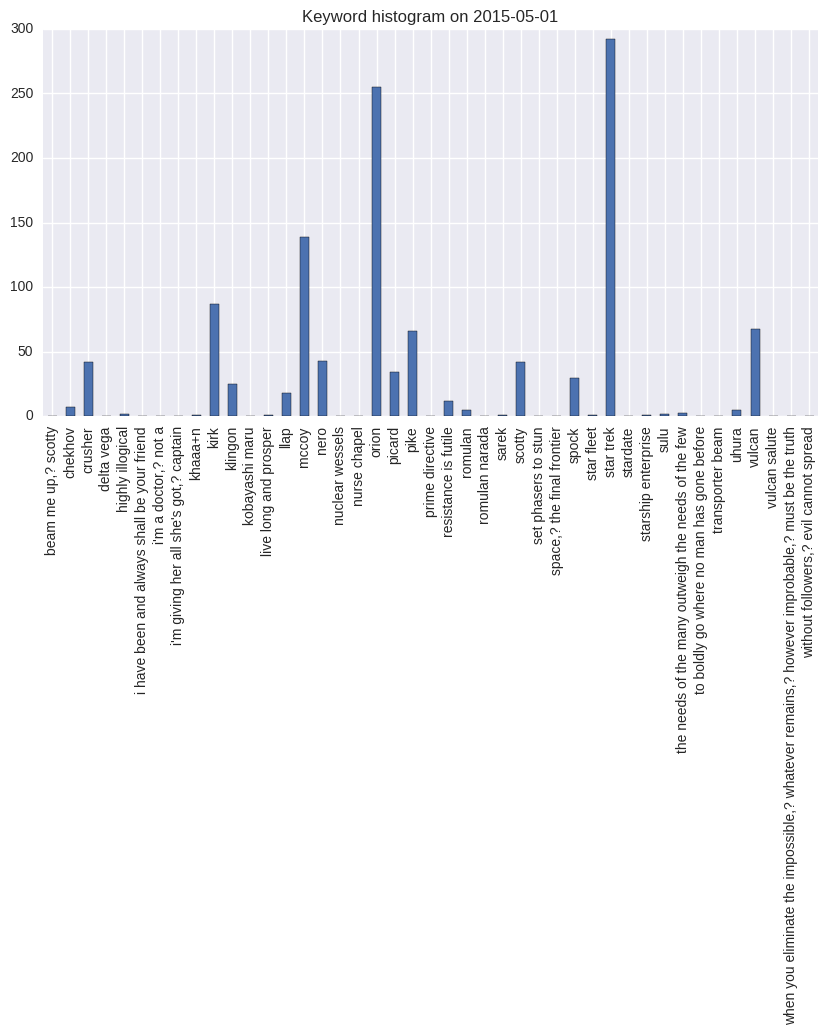

In [160]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [161]:
%%time

text_ = ''
for x in controversial_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 11.5 s, sys: 778 ms, total: 12.3 s
Wall time: 12.3 s


In [162]:
counter_.most_common(SHOW)

[("n't", 812),
 ('like', 396),
 ('star', 337),
 ('trek', 298),
 ('would', 298),
 ('people', 277),
 ('...', 266),
 ('one', 265),
 ('get', 251),
 ('game', 236),
 ('think', 231),
 ('orion', 228),
 ('even', 227),
 ('good', 200),
 ('make', 194),
 ('really', 177),
 ('could', 170),
 ('http', 170),
 ('better', 165),
 ('time', 159),
 ('much', 155),
 ('https', 155),
 ('know', 148),
 ('want', 143),
 ('see', 140),
 ('way', 139),
 ('mccoy', 133),
 ('also', 132),
 ('still', 129),
 ('going', 127),
 ('new', 127),
 ('amp', 124),
 ("'re", 122),
 ('right', 115),
 ('say', 111),
 ('back', 111),
 ('well', 107),
 ("'ve", 106),
 ('best', 104),
 ('play', 104),
 ('every', 104),
 ('year', 104),
 ('never', 102),
 ('first', 98),
 ('made', 97),
 ('need', 96),
 ('thing', 94),
 ('actually', 94),
 ('years', 92),
 ('last', 90),
 ('said', 90),
 ('something', 90),
 ('great', 85),
 ("'ll", 84),
 ('pretty', 84),
 ('work', 83),
 ('got', 83),
 ('kirk', 82),
 ('guy', 81),
 ('things', 80),
 ('without', 80),
 ('give', 80),
 ('s

###### n-grams

In [163]:
list_ = nltk.word_tokenize(text_)

In [164]:
counter_aux = Counter(dict(counter_.most_common(show_aux)))

###### 2-grams

In [165]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (2, 2))
    if any(map(lambda x: x in counter_aux, ng))
]

In [166]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [167]:
other_word_ngrams_counter.most_common(SHOW)

[(('star', 'trek'), 282),
 (('do', "n't"), 256),
 (('http', ':'), 170),
 (('(', 'http'), 135),
 (('does', "n't"), 104),
 (('i', 'think'), 103),
 (('the', 'orion'), 100),
 (('did', "n't"), 92),
 (('ca', "n't"), 83),
 (('is', "n't"), 77),
 (('the', 'game'), 74),
 (('to', 'make'), 66),
 (('one', 'of'), 65),
 (('would', 'be'), 63),
 (("n't", 'have'), 49),
 (('to', 'get'), 49),
 (('i', 'would'), 48),
 (('like', 'the'), 47),
 (('trek', '.'), 47),
 (('game', '.'), 44),
 (('...', '-'), 44),
 (('star', 'wars'), 44),
 (('a', 'good'), 43),
 (('better', 'than'), 42),
 (("n't", 'even'), 40),
 (('it', 'would'), 40),
 (('would', 'have'), 38),
 (('wo', "n't"), 36),
 (('would', "n't"), 35),
 (('the', 'star'), 35),
 (("n't", 'be'), 32),
 (("n't", 'think'), 32),
 (('even', 'if'), 30),
 (('think', 'it'), 30),
 (("n't", 'know'), 29),
 (('make', 'it'), 29),
 (('of', 'star'), 28),
 (('are', "n't"), 28),
 (('the', 'time'), 27),
 (('like', 'a'), 27),
 (('people', 'who'), 26),
 (('game', ','), 25),
 (('could', 

###### 3-grams

In [168]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (3, 3))
    if any(map(lambda x: x in counter_aux, ng))
]

In [169]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [170]:
other_word_ngrams_counter.most_common(SHOW)

[(('(', 'http', ':'), 135),
 ((']', '(', 'http'), 134),
 (('i', 'do', "n't"), 106),
 (('star', 'trek', '.'), 44),
 (('.', 'i', 'think'), 39),
 (('one', 'of', 'the'), 36),
 (('...', '-', '-'), 32),
 (('the', 'star', 'trek'), 29),
 (('you', 'do', "n't"), 26),
 (('do', "n't", 'have'), 25),
 (('of', 'star', 'trek'), 25),
 (('it', 'does', "n't"), 23),
 (('do', "n't", 'think'), 22),
 (('do', "n't", 'know'), 22),
 (('you', 'ca', "n't"), 22),
 (('it', 'would', 'be'), 21),
 (('i', 'did', "n't"), 17),
 (('i', 'ca', "n't"), 17),
 (('star', 'trek', ','), 16),
 (('star', 'trek', 'is'), 16),
 (('the', 'game', '.'), 15),
 (('.', 'star', 'trek'), 15),
 (('-', 'http', ':'), 15),
 (('i', 'think', 'it'), 15),
 (('.', 'do', "n't"), 15),
 (('in', 'the', 'game'), 14),
 (('do', "n't", 'even'), 14),
 (('.', 'i', 'would'), 14),
 (('in', 'star', 'trek'), 13),
 (('-', 'i', 'think'), 13),
 (('of', 'the', 'game'), 13),
 (('game', '.', '-'), 13),
 (('does', "n't", 'mean'), 13),
 (('a', 'star', 'trek'), 13),
 (('do'

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [171]:
%%time

sentiment_list = []
for x in controversial_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 943 ms, sys: 123 µs, total: 943 ms
Wall time: 942 ms


In [172]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [173]:
sentiment_df.head()

,body,sentiment,subjectivity
0,seems awfully harsh. plus star trek: into dark...,-0.20,0.70
1,i just talked to stan bowman. he says that bab...,0.20,0.50
2,"personally, i believe it's a sign that rose ty...",-0.02,0.60
3,please refrain from attacks on the star trek p...,0.42,0.42
4,man i wish i was a woman. i could rape from th...,0.00,0.00


In [174]:
sentiment_df['sentiment'].mean()

0.07289214560924627

In [175]:
sentiment_df['subjectivity'].mean()

0.43363619646802232

##### Histogram top positive

In [176]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(controversial_date_df) * P // 100]

In [177]:
top_df

,body,sentiment,subjectivity
974,ben affleck and rosamund pike were awesome in ...,1.00,1.00
149,they put you in charge of stealing the wifi no...,1.00,1.00
704,"i was like ""what a potatoe aim"" until i realis...",0.88,0.60
524,"good god no, not ds9! it was star trek, withou...",0.88,0.60
1097,we welcome you to /r/fatpeoplehate,0.80,0.90
507,am i supposed to be proud that you stopped scr...,0.80,1.00
315,i just finished watching kirk whoop chang's as...,0.80,0.70
433,who gives a damn lol,0.80,0.70
855,"justin thinks he's captain picard now, great.",0.80,0.75
749,"very good! i pike it a lot. in my mind, this i...",0.75,0.89


In [178]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 505 ms, sys: 20 ms, total: 525 ms
Wall time: 524 ms


In [179]:
top_counter = Counter(top_list)

In [180]:
top_counter.most_common(SHOW)

[('good', 36),
 ("n't", 36),
 ('orion', 31),
 ('star', 27),
 ('get', 24),
 ('better', 21),
 ('money', 21),
 ('trek', 21),
 ('would', 19),
 ('best', 19),
 ('like', 17),
 ('make', 13),
 ('think', 12),
 ('people', 12),
 ('could', 11),
 ('mccoy', 11),
 ('really', 11),
 ('got', 10),
 ('great', 10),
 ('even', 10),
 ('ads', 10),
 ('motherfucking', 9),
 ('time', 9),
 ('know', 9),
 ('actually', 9),
 ('...', 9),
 ('kirk', 8),
 ('one', 8),
 ('wars', 8),
 ('give', 8),
 ('still', 8),
 ('pike', 8),
 ('full', 7),
 ('need', 7),
 ('0.75', 7),
 ('love', 7),
 ('also', 6),
 ('lmgs', 6),
 ('read', 6),
 ('top', 6),
 ('going', 6),
 ('want', 6),
 ('film', 6),
 ('say', 6),
 ('vulcan', 6),
 ("'re", 6),
 ('http', 6),
 ('honestly', 6),
 ('edit', 6),
 ('mswr', 6),
 ('changed', 6),
 ('much', 6),
 ('tank', 5),
 ('guys', 5),
 ('lmg', 5),
 ('see', 5),
 ('look', 5),
 ('picard', 5),
 ('0.5', 5),
 ('spa', 5),
 ('modifier', 5),
 ('league', 5),
 ('aesop', 5),
 ("'ll", 5),
 ('done', 5),
 ('never', 5),
 ('put', 5),
 ('ever',

##### Histogram top negative

In [181]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(controversial_date_df) * P // 100]

In [182]:
top_df

,body,sentiment,subjectivity
300,evil capitali.....oohh look money...,-1.00,1.00
97,ds9 is worst star trek,-1.00,1.00
1143,this is terrible. - - you are qualified to w...,-1.00,1.00
861,1. tried pike - - 2. hated pike - - 3. i hat...,-0.85,0.80
741,"questo è razzismo, fare la barba ad un nero o ...",-0.80,1.00
677,"god damn it, i fuckin' hate it [when i'm right...",-0.80,0.90
548,abrams is the director! he didn't write the m...,-0.80,1.00
259,did... did *god* just fucking *flame* me?! - ...,-0.75,0.80
272,"the sick part is i read this and thought, ""huh...",-0.71,0.86
638,no but it got me off my fat ass and into the g...,-0.70,0.67


In [183]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 448 ms, sys: 39.7 ms, total: 488 ms
Wall time: 487 ms


In [184]:
top_counter = Counter(top_list)

In [185]:
top_counter.most_common(SHOW)

[("n't", 40),
 ('star', 31),
 ('trek', 30),
 ('like', 19),
 ('get', 19),
 ('fucking', 18),
 ('would', 16),
 ('game', 16),
 ('people', 15),
 ('fuck', 13),
 ('http', 13),
 ('orion', 12),
 ('mccoy', 11),
 ('one', 11),
 ('...', 11),
 ('going', 9),
 ('mean', 9),
 ('shit', 9),
 ('worst', 8),
 ('kirk', 8),
 ('something', 8),
 ('hate', 8),
 ('could', 7),
 ('bad', 7),
 ('sorry', 7),
 ('think', 7),
 ('made', 7),
 ('every', 7),
 ('stupid', 6),
 ('terrible', 6),
 ('though', 6),
 ('stop', 6),
 ('say', 6),
 ('keep', 6),
 ('guy', 6),
 ('ever', 6),
 ('least', 6),
 ('wrong', 6),
 ('really', 6),
 ('got', 5),
 ('see', 5),
 ('time', 5),
 ('things', 5),
 ('crusher', 5),
 ('way', 5),
 ('without', 5),
 ('movie', 5),
 ('always', 5),
 ("'ve", 5),
 ('point', 5),
 ('feel', 5),
 ('pike', 5),
 ('boring', 4),
 ('better', 4),
 ('read', 4),
 ('watch', 4),
 ('last', 4),
 ('reddit', 4),
 ('never', 4),
 ('stiff', 4),
 ('someone', 4),
 ('tell', 4),
 ('day', 4),
 ('awful', 4),
 ('end', 4),
 ('maybe', 4),
 ('want', 4),
 ('

In [186]:
peaks

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2015-08-01

In [187]:
date = '2015-08-01'

In [188]:
controversial_date_df = controversial_df[controversial_df['month'] == date]

In [189]:
len(controversial_date_df)

1295

#### Histogram

###### Keywords

In [190]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = controversial_date_df[controversial_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [191]:
keywords_counter = Counter(keywords_dict)

In [192]:
keywords_counter.most_common()

[('star trek', 368),
 ('orion', 166),
 ('kirk', 140),
 ('mccoy', 138),
 ('vulcan', 124),
 ('picard', 54),
 ('pike', 53),
 ('nero', 42),
 ('spock', 33),
 ('klingon', 27),
 ('scotty', 25),
 ('crusher', 15),
 ('prime directive', 9),
 ('romulan', 8),
 ('resistance is futile', 8),
 ('chekhov', 7),
 ('the needs of the many outweigh the needs of the few', 5),
 ('star fleet', 4),
 ('highly illogical', 3),
 ('live long and prosper', 3),
 ('llap', 3),
 ('beam me up,? scotty', 2),
 ('uhura', 1),
 ('stardate', 1),
 ('vulcan salute', 1),
 ('sulu', 1),
 ('nuclear wessels', 1),
 ('set phasers to stun', 0),
 ('delta vega', 0),
 ('nurse chapel', 0),
 ('space,? the final frontier', 0),
 ('without followers,? evil cannot spread', 0),
 ('romulan narada', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('transporter beam', 0),
 ('kobayashi maru', 0),
 ('khaaa+n', 0),
 ("i'm a doctor,? not a", 0),
 ('to boldly go where no man has gone before', 0),
 ('starship enterprise', 0),
 ('i have been and always 

In [193]:
keywords_sr = pd.Series(keywords_dict)

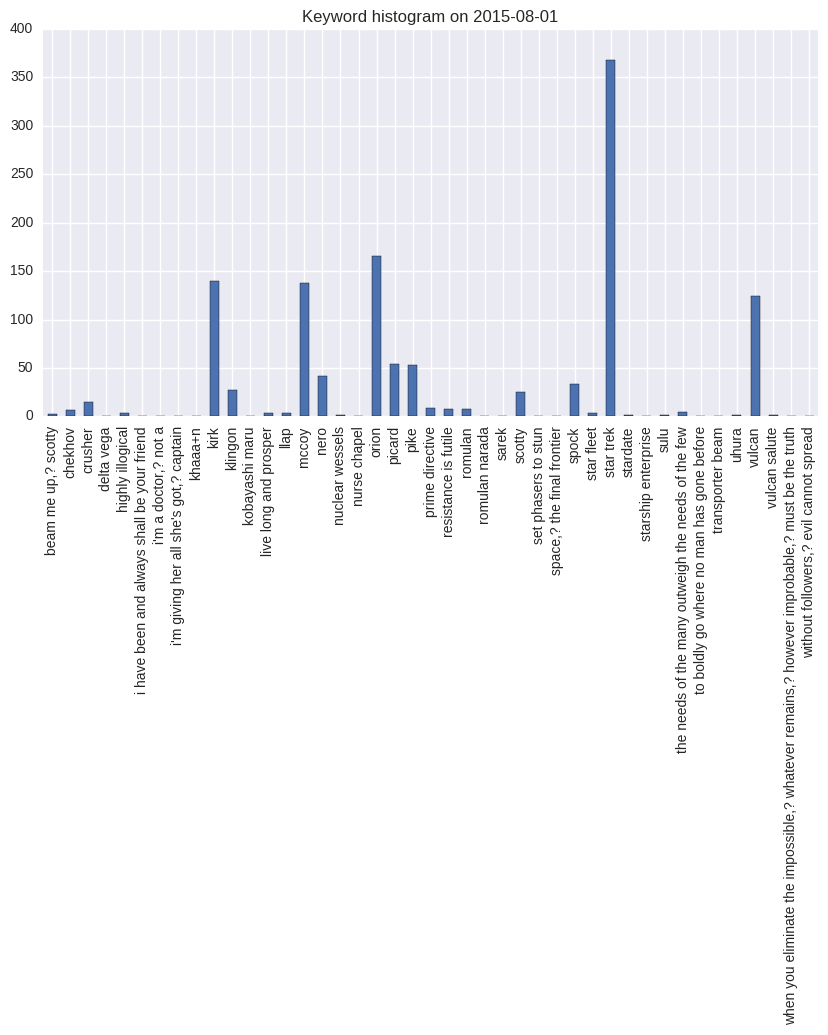

In [194]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [195]:
%%time

text_ = ''
for x in controversial_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 10.6 s, sys: 642 ms, total: 11.2 s
Wall time: 11.3 s


In [196]:
counter_.most_common(SHOW)

[("n't", 856),
 ('star', 424),
 ('like', 408),
 ('trek', 388),
 ('people', 350),
 ('would', 299),
 ('one', 288),
 ('get', 241),
 ('think', 229),
 ('...', 215),
 ('even', 195),
 ("'re", 188),
 ('game', 182),
 ('really', 168),
 ('good', 164),
 ('time', 162),
 ('going', 162),
 ('know', 158),
 ('see', 153),
 ('better', 150),
 ('orion', 148),
 ('much', 147),
 ('http', 141),
 ('also', 140),
 ('kirk', 135),
 ('could', 134),
 ('make', 133),
 ('mccoy', 128),
 ('still', 125),
 ('well', 121),
 ('way', 117),
 ('want', 114),
 ('vulcan', 114),
 ('new', 114),
 ('something', 113),
 ('say', 112),
 ('never', 106),
 ('thing', 102),
 ('shit', 100),
 ('first', 98),
 ("'ve", 96),
 ("'ll", 94),
 ('right', 93),
 ('pretty', 93),
 ('many', 92),
 ('things', 91),
 ('last', 88),
 ('best', 86),
 ('every', 86),
 ('bad', 83),
 ('back', 83),
 ('take', 83),
 ('year', 83),
 ('said', 82),
 ('point', 80),
 ('two', 80),
 ('actually', 78),
 ('show', 78),
 ('years', 78),
 ('got', 77),
 ('need', 76),
 ('look', 76),
 ('play', 

###### n-grams

In [197]:
list_ = nltk.word_tokenize(text_)

In [198]:
counter_aux = Counter(dict(counter_.most_common(show_aux)))

###### 2-grams

In [199]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (2, 2))
    if any(map(lambda x: x in counter_aux, ng))
]

In [200]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [201]:
other_word_ngrams_counter.most_common(SHOW)

[(('star', 'trek'), 351),
 (('do', "n't"), 267),
 (('does', "n't"), 119),
 (('is', "n't"), 105),
 (('you', "'re"), 104),
 (('going', 'to'), 102),
 (('did', "n't"), 89),
 (('i', 'think'), 86),
 (('the', 'game'), 82),
 (('one', 'of'), 76),
 (('ca', "n't"), 67),
 (('to', 'get'), 64),
 (('they', "'re"), 59),
 (('i', 'would'), 55),
 (('star', 'wars'), 53),
 (('would', 'be'), 52),
 (("n't", 'have'), 50),
 (('trek', '.'), 47),
 (('was', "n't"), 44),
 (('to', 'see'), 42),
 (('game', '.'), 40),
 (('you', 'think'), 39),
 (('like', 'a'), 37),
 (('better', 'than'), 37),
 (('would', "n't"), 36),
 (('you', 'know'), 36),
 (('people', 'who'), 36),
 (('time', '.'), 35),
 (('i', 'know'), 35),
 (("n't", 'know'), 34),
 (('the', 'star'), 34),
 (('would', 'have'), 33),
 (('like', 'the'), 33),
 (('are', "n't"), 32),
 (('of', 'people'), 32),
 (('is', 'going'), 30),
 (("n't", 'be'), 29),
 (('a', 'good'), 29),
 (('it', 'would'), 28),
 (('of', 'star'), 27),
 (('the', 'time'), 26),
 (('...', '.'), 25),
 (("n't", 

###### 3-grams

In [202]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (3, 3))
    if any(map(lambda x: x in counter_aux, ng))
]

In [203]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [204]:
other_word_ngrams_counter.most_common(SHOW)

[(('i', 'do', "n't"), 101),
 (('one', 'of', 'the'), 44),
 (('star', 'trek', '.'), 42),
 (('it', 'does', "n't"), 34),
 (('the', 'star', 'trek'), 32),
 (('going', 'to', 'be'), 28),
 (('do', "n't", 'know'), 27),
 (('you', 'do', "n't"), 27),
 (('of', 'star', 'trek'), 24),
 (('do', "n't", 'have'), 24),
 (('is', 'going', 'to'), 23),
 (('.', 'i', 'think'), 22),
 (('star', 'trek', ','), 21),
 (('the', 'game', '.'), 20),
 (('in', 'the', 'game'), 19),
 (('i', 'did', "n't"), 18),
 (('do', "n't", 'think'), 18),
 (('.', 'star', 'trek'), 18),
 (('a', 'star', 'trek'), 18),
 (('do', "n't", 'like'), 17),
 (('you', 'ca', "n't"), 17),
 (('...', '-', '-'), 16),
 (('i', 'ca', "n't"), 16),
 (('.', 'do', "n't"), 16),
 (('in', 'star', 'trek'), 16),
 (('do', "n't", 'get'), 15),
 (('not', 'going', 'to'), 15),
 (('just', 'do', "n't"), 15),
 (('if', 'you', "'re"), 14),
 (('does', "n't", 'matter'), 13),
 (('do', 'you', 'think'), 13),
 (('of', 'the', 'game'), 13),
 (('they', 'do', "n't"), 13),
 (('i', "'m", 'going'

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [205]:
%%time

sentiment_list = []
for x in controversial_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 888 ms, sys: 0 ns, total: 888 ms
Wall time: 887 ms


In [206]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [207]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"first the whole star trek complaining, then tr...",0.23,0.37
1,and it's scotty pods bobblehead day!!,0.00,0.00
2,"the mods and i agree, but when we suggest to r...",-0.50,0.73
3,"because, at least in the cape books that i've ...",0.09,0.66
4,the commentary is very bland that is pretty mu...,0.08,0.73


In [208]:
sentiment_df['sentiment'].mean()

0.075537284045570918

In [209]:
sentiment_df['subjectivity'].mean()

0.43922376850800848

##### Histogram top positive

In [210]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(controversial_date_df) * P // 100]

In [211]:
top_df

,body,sentiment,subjectivity
92,but picard is awesome and foucault is not.,1.00,1.00
587,"nero is best girl in france, heretic",1.00,0.30
527,captain kirk is the best qb on this roster.,1.00,0.30
13,we prefer the star trek: voyager series--but p...,1.00,0.30
1016,the feminist tears are going to be delicious. ...,1.00,1.00
841,kirk cant even get ahead of colt mccoy on the ...,0.90,0.50
1143,i'm feeling good about this one! still have fl...,0.88,0.60
479,call him a homophobic slur just for good measu...,0.88,0.60
498,"""may the force be ever in your favor, mr. spoc...",0.80,0.75
825,"rock, paper, scissors, lizard spock? great ana...",0.80,0.75


In [212]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 413 ms, sys: 15.7 ms, total: 428 ms
Wall time: 431 ms


In [213]:
top_counter = Counter(top_list)

In [214]:
top_counter.most_common(SHOW)

[('star', 29),
 ("n't", 28),
 ('trek', 28),
 ('better', 24),
 ('good', 23),
 ('like', 20),
 ('best', 19),
 ('kirk', 16),
 ('think', 14),
 ('...', 13),
 ('mccoy', 12),
 ('great', 12),
 ('one', 12),
 ('vulcan', 11),
 ('people', 10),
 ('get', 10),
 ('lol', 9),
 ('would', 9),
 ('show', 9),
 ('orion', 9),
 ('see', 8),
 ('top', 8),
 ('going', 8),
 ('know', 8),
 ('even', 8),
 ("'re", 8),
 ('said', 7),
 ('team', 7),
 ('take', 7),
 ('still', 7),
 ('really', 7),
 ('spock', 6),
 ('look', 6),
 ('question', 6),
 ('many', 6),
 ('way', 6),
 ('never', 6),
 ('every', 6),
 ('tng', 5),
 ('well', 5),
 ('nice', 5),
 ('part', 5),
 ('sure', 5),
 ('could', 5),
 ('dont', 5),
 ('give', 5),
 ('nero', 5),
 ('films', 5),
 ('always', 5),
 ('right', 5),
 ('life', 5),
 ('players', 5),
 ('new', 5),
 ('series', 5),
 ('able', 4),
 ('need', 4),
 ('picard', 4),
 ('colt', 4),
 ('cool', 4),
 ("'ll", 4),
 ('change', 4),
 ('man', 4),
 ('huge', 4),
 ('rg3', 4),
 ('also', 4),
 ('captain', 4),
 ("'ve", 4),
 ('though', 4),
 ('ful

##### Histogram top negative

In [215]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(controversial_date_df) * P // 100]

In [216]:
top_df

,body,sentiment,subjectivity
209,been with dr who since mccoy and capaldi is th...,-1.00,1.00
379,"captian janeway, commander william riker, tom ...",-0.94,1.00
261,don't care if it stands for barbecue and eels....,-0.80,0.90
454,he looks like a retarded klingon,-0.80,0.80
694,its like people are fucking stupid or something.,-0.80,1.00
73,how to generalize 101 with mc - - i don't agr...,-0.78,0.60
292,"dirty dee, you're a baddy daddy lamatai tebby ...",-0.75,0.80
1201,stop calling it vulcan :(,-0.75,1.00
981,i think for me it wasn't that 2009 was a bad m...,-0.70,0.67
463,"i'll take the ""bad"" recoil of the orion any da...",-0.70,0.67


In [217]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 468 ms, sys: 35.9 ms, total: 504 ms
Wall time: 504 ms


In [218]:
top_counter = Counter(top_list)

In [219]:
top_counter.most_common(SHOW)

[("n't", 54),
 ('star', 28),
 ('trek', 28),
 ('like', 20),
 ('people', 19),
 ('bad', 18),
 ('fuck', 15),
 ('orion', 15),
 ('one', 14),
 ('get', 14),
 ('mccoy', 12),
 ('vulcan', 12),
 ('hate', 12),
 ('think', 11),
 ('shit', 11),
 ('really', 11),
 ('going', 10),
 ('...', 10),
 ('game', 10),
 ('would', 9),
 ('want', 9),
 ('could', 9),
 ('kirk', 8),
 ('fucking', 8),
 ("'re", 8),
 ('got', 7),
 ('something', 7),
 ('nerf', 7),
 ('see', 7),
 ('colt', 7),
 ('know', 7),
 ('never', 7),
 ('looks', 7),
 ('keep', 7),
 ('thing', 7),
 ('worst', 6),
 ('trying', 6),
 ('day', 6),
 ('line', 6),
 ('look', 6),
 ('stupid', 6),
 ('way', 6),
 ('http', 6),
 ('two', 6),
 ('long', 6),
 ('movie', 6),
 ('wrong', 6),
 ("'ve", 6),
 ('also', 5),
 ('well', 5),
 ('yeah', 5),
 ('time', 5),
 ('awful', 5),
 ('make', 5),
 ('sorry', 5),
 ("'ll", 5),
 ('edit', 5),
 ('everything', 5),
 ('behind', 5),
 ('even', 5),
 ('actually', 5),
 ('prowler', 5),
 ('ever', 5),
 ('let', 5),
 ('scotty', 5),
 ('side', 5),
 ('still', 5),
 ('poin

In [220]:
peaks

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2015-12-01

In [221]:
date = '2015-12-01'

In [222]:
controversial_date_df = controversial_df[controversial_df['month'] == date]

In [223]:
len(controversial_date_df)

1630

#### Histogram

###### Keywords

In [224]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = controversial_date_df[controversial_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [225]:
keywords_counter = Counter(keywords_dict)

In [226]:
keywords_counter.most_common()

[('star trek', 1053),
 ('kirk', 278),
 ('mccoy', 180),
 ('scotty', 122),
 ('orion', 87),
 ('spock', 80),
 ('pike', 52),
 ('picard', 48),
 ('vulcan', 45),
 ('crusher', 41),
 ('nero', 30),
 ('klingon', 23),
 ('prime directive', 21),
 ('uhura', 16),
 ('sulu', 11),
 ('live long and prosper', 9),
 ('resistance is futile', 8),
 ('llap', 5),
 ('highly illogical', 4),
 ('delta vega', 3),
 ('romulan', 3),
 ('khaaa+n', 3),
 ('the needs of the many outweigh the needs of the few', 2),
 ('chekhov', 2),
 ('star fleet', 2),
 ('kobayashi maru', 2),
 ("i'm a doctor,? not a", 2),
 ('starship enterprise', 2),
 ('beam me up,? scotty', 1),
 ('space,? the final frontier', 1),
 ('set phasers to stun', 0),
 ('stardate', 0),
 ('vulcan salute', 0),
 ('nurse chapel', 0),
 ('without followers,? evil cannot spread', 0),
 ('romulan narada', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('transporter beam', 0),
 ('to boldly go where no man has gone before', 0),
 ('nuclear wessels', 0),
 ('i have been and alwa

In [227]:
keywords_sr = pd.Series(keywords_dict)

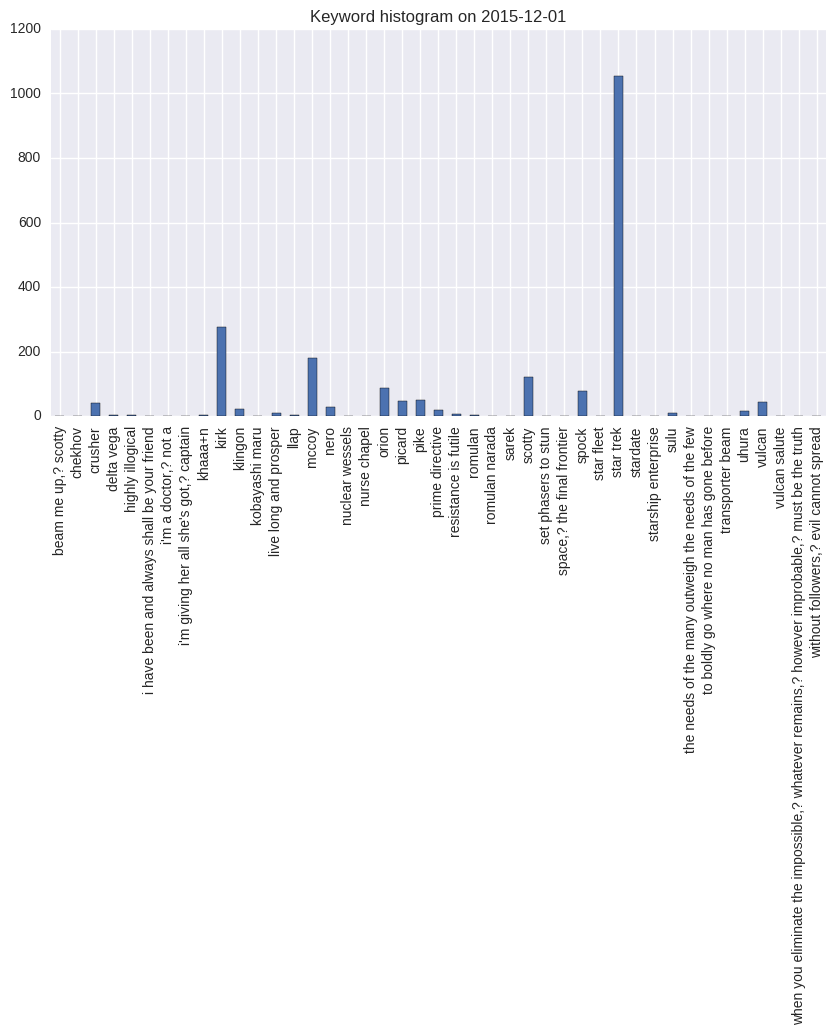

In [228]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [229]:
%%time

text_ = ''
for x in controversial_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 17.7 s, sys: 1.11 s, total: 18.8 s
Wall time: 18.8 s


In [230]:
counter_.most_common(SHOW)

[("n't", 1493),
 ('star', 1385),
 ('trek', 1174),
 ('like', 800),
 ('people', 486),
 ('would', 452),
 ('movie', 407),
 ('one', 402),
 ('...', 391),
 ('think', 346),
 ('know', 334),
 ('even', 327),
 ('good', 324),
 ('wars', 319),
 ('get', 288),
 ('really', 284),
 ("'re", 283),
 ('much', 282),
 ('movies', 278),
 ('kirk', 268),
 ('new', 268),
 ('could', 244),
 ('see', 241),
 ('time', 228),
 ('also', 219),
 ('better', 210),
 ('make', 205),
 ('first', 197),
 ('way', 192),
 ('still', 190),
 ('fans', 190),
 ('film', 185),
 ('going', 182),
 ("'ve", 182),
 ('game', 182),
 ('well', 180),
 ('mccoy', 175),
 ('want', 165),
 ('something', 164),
 ('bad', 159),
 ('things', 155),
 ('say', 155),
 ('made', 151),
 ('thing', 151),
 ('got', 149),
 ('never', 145),
 ('back', 139),
 ('great', 138),
 ('action', 131),
 ('many', 130),
 ('right', 129),
 ('team', 126),
 ('abrams', 125),
 ('need', 125),
 ('look', 124),
 ('scotty', 122),
 ('actually', 122),
 ('lot', 121),
 ('characters', 121),
 ('two', 120),
 ('serie

###### n-grams

In [231]:
list_ = nltk.word_tokenize(text_)

In [232]:
counter_aux = Counter(dict(counter_.most_common(show_aux)))

###### 2-grams

In [233]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (2, 2))
    if any(map(lambda x: x in counter_aux, ng))
]

In [234]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [235]:
other_word_ngrams_counter.most_common(SHOW)

[(('star', 'trek'), 1004),
 (('do', "n't"), 417),
 (('star', 'wars'), 308),
 (('does', "n't"), 267),
 (('i', 'think'), 174),
 (('did', "n't"), 163),
 (('you', "'re"), 159),
 (("n't", 'know'), 156),
 (('trek', '.'), 145),
 (('ca', "n't"), 131),
 (('is', "n't"), 130),
 (('the', 'star'), 101),
 (('the', 'movie'), 100),
 (('know', 'scotty'), 95),
 (('of', 'star'), 92),
 (('would', 'be'), 92),
 (('like', 'a'), 90),
 (('they', "'re"), 89),
 (('was', "n't"), 88),
 (('.', 'star'), 83),
 (('one', 'of'), 82),
 (('like', 'the'), 79),
 (('trek', ','), 77),
 (('a', 'star'), 76),
 (('movie', '.'), 75),
 (('a', 'good'), 71),
 (('to', 'get'), 70),
 (('i', 'would'), 65),
 (('in', 'star'), 63),
 (("n't", 'have'), 63),
 (('trek', 'is'), 61),
 (('are', "n't"), 59),
 (('would', 'have'), 58),
 (('people', 'who'), 57),
 (('would', "n't"), 55),
 (('movies', '.'), 51),
 (('wo', "n't"), 50),
 (("n't", 'even'), 50),
 (("n't", 'be'), 48),
 (('trek', 'fans'), 47),
 (('it', 'would'), 47),
 (('this', 'movie'), 46),


###### 3-grams

In [236]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (3, 3))
    if any(map(lambda x: x in counter_aux, ng))
]

In [237]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [238]:
other_word_ngrams_counter.most_common(SHOW)

[(('i', 'do', "n't"), 165),
 (('star', 'trek', '.'), 125),
 (('does', "n't", 'know'), 104),
 (('scotty', 'does', "n't"), 96),
 (("n't", 'know', 'scotty'), 95),
 (('know', 'scotty', 'does'), 95),
 (('of', 'star', 'trek'), 80),
 (('star', 'trek', ','), 68),
 (('the', 'star', 'trek'), 65),
 (('.', 'star', 'trek'), 61),
 (('one', 'of', 'the'), 53),
 (('star', 'trek', 'is'), 51),
 (('.', 'i', 'think'), 49),
 (('a', 'star', 'trek'), 46),
 (('you', 'do', "n't"), 45),
 (('in', 'star', 'trek'), 45),
 (('do', "n't", 'know'), 41),
 (('star', 'trek', 'movies'), 40),
 (('star', 'trek', 'fans'), 39),
 (('star', 'wars', '.'), 37),
 (('star', 'trek', ':'), 35),
 (('i', 'did', "n't"), 34),
 (('star', 'trek', 'and'), 34),
 (('i', 'ca', "n't"), 33),
 (('star', 'trek', 'movie'), 32),
 (('do', "n't", 'think'), 32),
 (('they', 'do', "n't"), 31),
 (('star', 'trek', 'into'), 30),
 (('do', "n't", 'want'), 30),
 (('trek', '.', '-'), 29),
 ((',', 'i', 'think'), 29),
 (('like', 'star', 'trek'), 28),
 (('the', 'st

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [239]:
%%time

sentiment_list = []
for x in controversial_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 1.29 s, sys: 67 µs, total: 1.29 s
Wall time: 1.29 s


In [240]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [241]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"if this is real, then you're just an idiot",-0.30,0.55
1,"it's one of my favorite movies, no bullshit. ...",0.03,0.54
2,probably for the same reason all modern democr...,0.03,0.31
3,i'm midcore and have cleared it. it's absurd t...,-0.38,0.82
4,6081. - desperately wanting to become part of ...,0.04,0.61


In [242]:
sentiment_df['sentiment'].mean()

0.057923621283377094

In [243]:
sentiment_df['subjectivity'].mean()

0.46102886798506837

##### Histogram top positive

In [244]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(controversial_date_df) * P // 100]

In [245]:
top_df

,body,sentiment,subjectivity
602,"""let's not do this again"" great advice! don't ...",1.00,0.75
307,i think i can tell the difference between hip ...,1.00,1.00
1477,the orion remains awesome.,1.00,1.00
1505,"now, i'm not going to speculate that chip kell...",1.00,0.53
1612,"also, the best star trek film ever was called ...",1.00,0.30
1579,p4p best can crusher in the world.,1.00,0.30
1450,"i wouldn't go pierce, but parsons is a dart th...",1.00,0.30
382,&gt;kelly’s rationale would be easier to swall...,0.83,0.37
1050,"i love star trek, however the best star wars f...",0.83,0.40
811,and shitting all over it in the process. they ...,0.81,0.40


In [246]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 708 ms, sys: 68 ms, total: 776 ms
Wall time: 776 ms


In [247]:
top_counter = Counter(top_list)

In [248]:
top_counter.most_common(SHOW)

[('star', 115),
 ('trek', 94),
 ("n't", 49),
 ('like', 43),
 ('good', 30),
 ('kirk', 29),
 ('best', 29),
 ('would', 29),
 ('...', 24),
 ('wars', 23),
 ('movies', 22),
 ('think', 21),
 ('great', 21),
 ('people', 21),
 ('mccoy', 18),
 ("'re", 18),
 ('better', 18),
 ('movie', 18),
 ('one', 17),
 ('also', 15),
 ('love', 14),
 ('know', 14),
 ('two', 14),
 ('need', 13),
 ('got', 13),
 ('really', 13),
 ('much', 13),
 ('could', 12),
 ('make', 12),
 ('want', 12),
 ('get', 12),
 ('action', 12),
 ('still', 12),
 ('new', 11),
 ('something', 10),
 ('see', 10),
 ('well', 10),
 ('original', 10),
 ('fun', 10),
 ('say', 10),
 ('way', 10),
 ('top', 9),
 ('said', 9),
 ('let', 9),
 ("'ve", 9),
 ('film', 9),
 ('first', 9),
 ('films', 9),
 ('time', 8),
 ('series', 8),
 ('saying', 8),
 ('even', 8),
 ('fans', 8),
 ('lol', 8),
 ('cousins', 8),
 ('things', 8),
 ('sure', 8),
 ('many', 7),
 ('orion', 7),
 ('fine', 7),
 ('another', 7),
 ('world', 7),
 ('years', 7),
 ('play', 7),
 ('made', 7),
 ('guy', 7),
 ('ever'

##### Histogram top negative

In [249]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(controversial_date_df) * P // 100]

In [250]:
top_df

,body,sentiment,subjectivity
1280,please tell me you have him a vicious beating,-1.00,1.00
1444,"assault rifles? what, do you hate freedom?! ba...",-1.00,0.90
573,jj star trek was horrible.,-1.00,1.00
652,quinto's spock is one of the worst parts.,-1.00,1.00
1385,worst day ever. and the worst part is that kir...,-1.00,1.00
905,story quasi ein remake mit ständigen und irgen...,-1.00,1.00
1202,so was the point that star trek: beyond will b...,-0.85,0.83
476,it is in hots terms? - - did i say champion ...,-0.80,0.90
430,probably because i hate star trek.,-0.80,0.90
1216,"i didn't hate it, i just don't think it's of t...",-0.80,0.90


In [251]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 661 ms, sys: 55.8 ms, total: 717 ms
Wall time: 717 ms


In [252]:
top_counter = Counter(top_list)

In [253]:
top_counter.most_common(SHOW)

[('star', 93),
 ('trek', 84),
 ("n't", 61),
 ('like', 48),
 ('fuck', 29),
 ('mccoy', 28),
 ('...', 28),
 ('bad', 19),
 ('fucking', 17),
 ('kirk', 16),
 ('hate', 15),
 ('say', 15),
 ('game', 15),
 ('one', 14),
 ('even', 13),
 ('http', 13),
 ('get', 13),
 ('people', 13),
 ('fan', 12),
 ('fans', 12),
 ('movies', 12),
 ('think', 12),
 ('movie', 12),
 ("'re", 11),
 ('would', 11),
 ('see', 11),
 ('nothing', 11),
 ('wars', 11),
 ('said', 10),
 ('worst', 10),
 ("'ll", 9),
 ('know', 9),
 ('way', 9),
 ('looks', 8),
 ('shit', 8),
 ('well', 8),
 ('new', 8),
 ('det', 8),
 ('though', 8),
 ('something', 7),
 ('want', 7),
 ('die', 7),
 ('play', 7),
 ('away', 7),
 ('base', 7),
 ('never', 7),
 ('things', 7),
 ('also', 6),
 ('crap', 6),
 ('stop', 6),
 ('sorry', 6),
 ('cousins', 6),
 ('instead', 6),
 ('give', 6),
 ('either', 6),
 ('hard', 6),
 ('currency', 6),
 ('yeah', 6),
 ('film', 6),
 ('horrible', 6),
 ('terrible', 6),
 ('going', 6),
 ('look', 6),
 ('team', 6),
 ('hope', 6),
 ('still', 6),
 ('science'

In [254]:
peaks

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2016-07-01

In [255]:
date = '2016-07-01'

In [256]:
controversial_date_df = controversial_df[controversial_df['month'] == date]

In [257]:
len(controversial_date_df)

1657

#### Histogram

###### Keywords

In [258]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = controversial_date_df[controversial_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [259]:
keywords_counter = Counter(keywords_dict)

In [260]:
keywords_counter.most_common()

[('star trek', 882),
 ('sulu', 294),
 ('kirk', 218),
 ('spock', 137),
 ('nero', 107),
 ('vulcan', 107),
 ('pike', 86),
 ('orion', 59),
 ('scotty', 53),
 ('klingon', 49),
 ('uhura', 36),
 ('mccoy', 34),
 ('crusher', 33),
 ('picard', 32),
 ('romulan', 26),
 ('prime directive', 12),
 ('resistance is futile', 10),
 ('chekhov', 9),
 ('star fleet', 5),
 ('highly illogical', 4),
 ('beam me up,? scotty', 3),
 ('the needs of the many outweigh the needs of the few', 3),
 ('kobayashi maru', 3),
 ('khaaa+n', 3),
 ("i'm a doctor,? not a", 2),
 ('to boldly go where no man has gone before', 2),
 ('starship enterprise', 2),
 ('llap', 2),
 ('live long and prosper', 1),
 ('set phasers to stun', 0),
 ('stardate', 0),
 ('delta vega', 0),
 ('vulcan salute', 0),
 ('nurse chapel', 0),
 ('space,? the final frontier', 0),
 ('without followers,? evil cannot spread', 0),
 ('romulan narada', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('transporter beam', 0),
 ('nuclear wessels', 0),
 ('i have been and a

In [261]:
keywords_sr = pd.Series(keywords_dict)

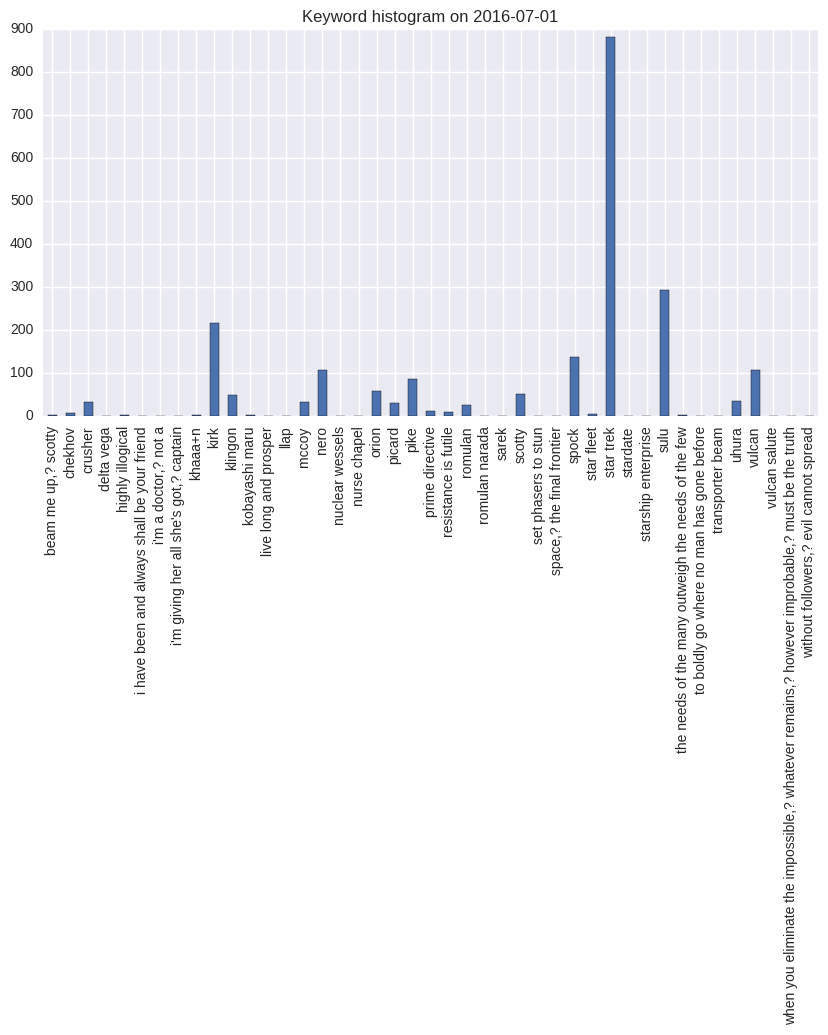

In [262]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [263]:
%%time

text_ = ''
for x in controversial_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 16.3 s, sys: 1.01 s, total: 17.3 s
Wall time: 17.3 s


In [264]:
counter_.most_common(SHOW)

[("n't", 1359),
 ('trek', 971),
 ('star', 951),
 ('like', 742),
 ('people', 501),
 ('would', 477),
 ('one', 407),
 ('...', 347),
 ('gay', 344),
 ('movie', 340),
 ('new', 334),
 ('think', 325),
 ('character', 311),
 ('even', 300),
 ('get', 286),
 ('time', 284),
 ('sulu', 283),
 ('see', 277),
 ('good', 258),
 ("'re", 256),
 ('make', 241),
 ('also', 238),
 ('really', 236),
 ('could', 230),
 ('want', 212),
 ('kirk', 212),
 ('movies', 202),
 ('know', 200),
 ('way', 193),
 ('going', 188),
 ('much', 181),
 ('first', 181),
 ('something', 175),
 ('made', 165),
 ('still', 164),
 ('well', 164),
 ("'ve", 159),
 ('thing', 155),
 ('never', 154),
 ('show', 153),
 ('better', 153),
 ('bad', 150),
 ('https', 144),
 ('point', 141),
 ('series', 140),
 ('back', 139),
 ('characters', 138),
 ('ship', 135),
 ('actually', 134),
 ('things', 132),
 ('got', 129),
 ('spock', 128),
 ('lot', 126),
 ('many', 126),
 ('game', 125),
 ('say', 120),
 ('shit', 117),
 ('original', 116),
 ('though', 115),
 ('film', 114),
 ('

###### n-grams

In [265]:
list_ = nltk.word_tokenize(text_)

In [266]:
counter_aux = Counter(dict(counter_.most_common(show_aux)))

###### 2-grams

In [267]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (2, 2))
    if any(map(lambda x: x in counter_aux, ng))
]

In [268]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [269]:
other_word_ngrams_counter.most_common(SHOW)

[(('star', 'trek'), 849),
 (('do', "n't"), 422),
 (('did', "n't"), 157),
 (('does', "n't"), 156),
 (('i', 'think'), 147),
 (('is', "n't"), 132),
 (('the', 'new'), 128),
 (('ca', "n't"), 126),
 (('you', "'re"), 118),
 (('trek', '.'), 102),
 (('would', 'be'), 100),
 (('to', 'see'), 100),
 (('one', 'of'), 100),
 (('they', "'re"), 97),
 (('the', 'movie'), 93),
 (('was', "n't"), 84),
 (('to', 'get'), 79),
 (('like', 'the'), 78),
 (('a', 'new'), 74),
 (('i', 'would'), 70),
 (('a', 'good'), 70),
 (('the', 'star'), 69),
 (("n't", 'have'), 68),
 (('movie', '.'), 67),
 (('star', 'wars'), 66),
 (('the', 'time'), 64),
 (('trek', ','), 63),
 (('of', 'star'), 62),
 (('would', 'have'), 60),
 (("n't", 'think'), 60),
 (('like', 'a'), 59),
 (('are', "n't"), 57),
 (('time', '.'), 57),
 (('gay', '.'), 56),
 (("n't", 'be'), 55),
 (('people', 'who'), 55),
 (('.', 'star'), 55),
 (('would', "n't"), 54),
 (('a', 'star'), 50),
 (('a', 'character'), 49),
 (('it', 'would'), 49),
 (('like', 'it'), 49),
 (('wo', "n

###### 3-grams

In [270]:
other_word_ngrams_list = [
    ng
    for ng in my_ngrams(list_, (3, 3))
    if any(map(lambda x: x in counter_aux, ng))
]

In [271]:
other_word_ngrams_counter = Counter(other_word_ngrams_list)

In [272]:
other_word_ngrams_counter.most_common(SHOW)

[(('i', 'do', "n't"), 169),
 (('star', 'trek', '.'), 89),
 (('the', 'star', 'trek'), 61),
 (('of', 'star', 'trek'), 61),
 (('one', 'of', 'the'), 61),
 (('do', "n't", 'think'), 53),
 (('star', 'trek', ','), 53),
 (('you', 'do', "n't"), 49),
 (('.', 'star', 'trek'), 46),
 (('a', 'star', 'trek'), 46),
 (('star', 'trek', 'is'), 41),
 (('new', 'star', 'trek'), 40),
 (('in', 'star', 'trek'), 36),
 (('star', 'trek', 'movie'), 35),
 (('...', '-', '-'), 35),
 (('star', 'trek', 'and'), 33),
 (('you', 'ca', "n't"), 33),
 (('do', "n't", 'want'), 32),
 (('do', "n't", 'like'), 31),
 (('it', 'was', "n't"), 31),
 (('.', 'i', 'think'), 31),
 (('star', 'trek', 'movies'), 31),
 (('it', 'does', "n't"), 29),
 (('star', 'trek', ':'), 29),
 ((',', 'star', 'trek'), 28),
 ((',', 'i', 'think'), 28),
 (("n't", 'want', 'to'), 27),
 (('i', 'did', "n't"), 26),
 (('star', 'trek', 'was'), 26),
 (('think', 'it', "'s"), 26),
 (('do', "n't", 'know'), 26),
 (('the', 'new', 'star'), 26),
 (('they', 'do', "n't"), 25),
 (('

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [273]:
%%time

sentiment_list = []
for x in controversial_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 1.3 s, sys: 146 µs, total: 1.3 s
Wall time: 1.3 s


In [274]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [275]:
sentiment_df.head()

,body,sentiment,subjectivity
0,did they play that stupid ass rihanna music vi...,0.10,0.65
1,"atheists be like - - jokes aside, i think wi...",0.50,0.60
2,i did really dig horizon. i haven't seen enter...,0.39,0.50
3,"oh yeah, i tend to forget about tna things tha...",0.00,0.00
4,i like star trek continues and new voyages/pha...,0.26,0.38


In [276]:
sentiment_df['sentiment'].mean()

0.075856838605302429

In [277]:
sentiment_df['subjectivity'].mean()

0.48136705079668551

##### Histogram top positive

In [278]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(controversial_date_df) * P // 100]

In [279]:
top_df

,body,sentiment,subjectivity
1444,uh... no. people would say it was the best sta...,1.00,0.30
1118,there's no need to check history at all&gt; i ...,1.00,1.00
989,i think cryptic has the best mission names of ...,1.00,0.30
941,i won't be. i'll be doing my best to show them...,1.00,0.30
661,i have a son named orion. awesome name. before...,1.00,1.00
89,and case mccoy never should've gotten the pass...,1.00,0.30
1330,now i want to see elon as james t. kirk with a...,1.00,1.00
57,this guy. brilliant.,0.90,1.00
684,women can't be beautiful anymore pointing out ...,0.85,1.00
719,&gt;i think jj abram's trek reboot was great. ...,0.80,0.75


In [280]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 631 ms, sys: 40.2 ms, total: 672 ms
Wall time: 671 ms


In [281]:
top_counter = Counter(top_list)

In [282]:
top_counter.most_common(SHOW)

[("n't", 65),
 ('star', 64),
 ('trek', 61),
 ('like', 36),
 ('good', 31),
 ('gay', 31),
 ('sulu', 27),
 ('...', 25),
 ('great', 25),
 ('best', 22),
 ('get', 21),
 ('better', 21),
 ('think', 19),
 ('people', 18),
 ("'re", 17),
 ('even', 16),
 ('character', 16),
 ('would', 15),
 ('make', 14),
 ('vulcan', 14),
 ('kirk', 13),
 ('one', 13),
 ('love', 13),
 ("'ll", 12),
 ('see', 12),
 ('movies', 12),
 ('nice', 11),
 ('well', 11),
 ('takei', 11),
 ('time', 10),
 ('fans', 10),
 ('original', 10),
 ('made', 10),
 ('name', 10),
 ('orion', 9),
 ('point', 9),
 ('water', 9),
 ('show', 9),
 ('many', 9),
 ('though', 9),
 ('new', 9),
 ('want', 8),
 ("'ve", 8),
 ('could', 8),
 ('say', 8),
 ('ever', 8),
 ('really', 8),
 ('maybe', 7),
 ('much', 7),
 ('awesome', 7),
 ('lot', 7),
 ('fan', 7),
 ('way', 7),
 ('never', 7),
 ('agree', 7),
 ('movie', 7),
 ('still', 7),
 ('characters', 7),
 ('top', 6),
 ('got', 6),
 ('thought', 6),
 ('tna', 6),
 ('work', 6),
 ('lol', 6),
 ('might', 6),
 ('spock', 6),
 ('sure', 6)

##### Histogram top negative

In [283]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(controversial_date_df) * P // 100]

In [284]:
top_df

,body,sentiment,subjectivity
734,jj abrams is a cancer inflicted upon the stat ...,-1.00,1.00
970,his nxt title run was the worst,-1.00,1.00
1125,"i flip between the sword of la noscea, the wan...",-1.00,1.00
1043,"i wouldn't say '09 was a terrible movie, but i...",-1.00,1.00
963,"neither, but i hear rod roddenberry hated the ...",-0.90,0.70
129,&gt; i think they have a problem with the ann...,-0.80,0.90
545,then you are an idiot and a dirtbag.,-0.80,0.80
77,people hate truths xdd.,-0.80,0.90
1329,if i was going to imagine what a warp core loo...,-0.80,0.90
482,the trailer looked fucking retarded - - not s...,-0.80,0.80


In [285]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if len(w) > 2 and w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 743 ms, sys: 55.9 ms, total: 799 ms
Wall time: 799 ms


In [286]:
top_counter = Counter(top_list)

In [287]:
top_counter.most_common(SHOW)

[("n't", 91),
 ('trek', 83),
 ('star', 76),
 ('bad', 35),
 ('movie', 28),
 ('would', 26),
 ('people', 24),
 ('like', 23),
 ('one', 21),
 ('kirk', 21),
 ('hate', 19),
 ('want', 18),
 ("'re", 18),
 ('shit', 18),
 ('...', 18),
 ('think', 18),
 ('wrong', 17),
 ('also', 17),
 ('worst', 17),
 ('even', 17),
 ('fucking', 17),
 ('make', 16),
 ('movies', 15),
 ('darkness', 13),
 ('get', 13),
 ('terrible', 13),
 ('going', 13),
 ('something', 11),
 ('spock', 11),
 ('see', 11),
 ('could', 11),
 ('know', 11),
 ('stupid', 10),
 ('let', 10),
 ('thing', 10),
 ('film', 10),
 ('first', 10),
 ('really', 10),
 ('new', 10),
 ('got', 9),
 ('fuck', 9),
 ('good', 9),
 ('fans', 9),
 ('watch', 9),
 ('mean', 9),
 ('hated', 9),
 ('ever', 9),
 ('game', 9),
 ('different', 9),
 ('time', 8),
 ('stop', 8),
 ('getting', 8),
 ('ship', 8),
 ('least', 8),
 ('show', 8),
 ('made', 8),
 ('mad', 8),
 ('every', 8),
 ('beyond', 7),
 ('look', 7),
 ('part', 7),
 ('orion', 7),
 ('nero', 7),
 ('well', 7),
 ('last', 7),
 ('way', 7),


### Top

In [288]:
top_scored_controversial = controversial_df.sort_values(['score'], ascending=False)[:len(controversial_df) * P // 100]

In [289]:
len(top_scored_controversial)

2889

In [290]:
top_scored_controversial.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
1832015,kn0thing,we don’t talk about individual employees out o...,1,2015-07-06 13:45:21,admin,0.0,0,csu0kmv,t1_csu0kmv,t1_csu0bko,745,announcements,745,2015-07-01,2015-01-01
2169123,CustosClavium,vote conservative. go to mass and am faithful ...,1,2015-12-22 11:04:08,0,0,1,cy7up7u,0,t3_3xtw78,298,AskReddit,298,2015-12-01,2015-01-01
1888675,CIearMind,star wars and star trek are the same thing,1,2015-08-07 07:55:32,0,0,0,ctuortd,0,t3_3g4blw,212,AskReddit,212,2015-08-01,2015-01-01
2592059,osomeansbear,"yes, let's trust the uc davis equivalent of th...",1,2016-07-28 04:05:37,0,0,0,d5u6p9g,0,t1_d5u516m,136,pics,136,2016-07-01,2016-01-01
2146977,mrgeologyguy,oh please. all the star trek films since aroun...,1,2015-12-14 11:47:59,0,0,0,cxysm6d,0,t1_cxyrqur,132,movies,132,2015-12-01,2015-01-01


In [291]:
top_scored_controversial.ix[1832015]['body']

"we don’t talk about individual employees out of respect for their privacy. -  - with our announcement on friday, we're phasing out our role being in-between interesting people and the reddit audience so that we can focus on helping remarkable people become redditors, not just stop by on a press tour. -  - the responsibilities of our talent relations team going forward is about integrating celebrities, politicians, and noteworthy people as consistent posters (like arnold, snoop, or bernie sanders {edit: or [captain kirk](http://reddit.com/user/williamshatner)}) rather than one off occurrences. instead of just working with them once a year to promote something via ama, we want to be a resource to help them to actually join the reddit community ([arnold does this remarkably well](https://np.reddit.com/r/movies/comments/3bu70z/watching_terminator_genesys_with_my_father_some/cspq0lo)). -  - we're still introducing and sourcing talent for amas, just now giving the moderators the autonomy to

#### Temporal evolution

In [292]:
df_by_month = pd.Series(top_scored_controversial.groupby('month')['id'].count())
df_by_month.index.name = None

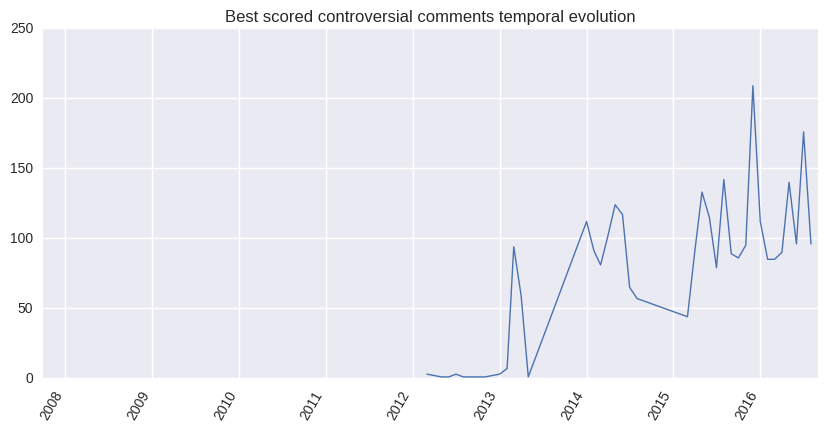

In [293]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=valid_dates,
    rot=60,
    title='Best scored controversial comments temporal evolution',
)
# ax.set_xticklabels(show_dates);

#### Histogram

In [294]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = top_scored_controversial['body'].str.count(k).sum()

CPU times: user 201 ms, sys: 341 µs, total: 201 ms
Wall time: 197 ms


In [295]:
keywords_counter = Counter(keywords_dict)

In [296]:
keywords_counter.most_common()

[('star trek', 1279),
 ('kirk', 319),
 ('orion', 255),
 ('mccoy', 209),
 ('pike', 168),
 ('spock', 166),
 ('vulcan', 130),
 ('picard', 91),
 ('nero', 90),
 ('crusher', 69),
 ('klingon', 67),
 ('sulu', 56),
 ('scotty', 50),
 ('prime directive', 30),
 ('uhura', 22),
 ('chekhov', 21),
 ('resistance is futile', 17),
 ('romulan', 15),
 ('llap', 15),
 ('live long and prosper', 13),
 ('highly illogical', 9),
 ('the needs of the many outweigh the needs of the few', 7),
 ('starship enterprise', 7),
 ('beam me up,? scotty', 4),
 ('star fleet', 4),
 ('kobayashi maru', 2),
 ('set phasers to stun', 1),
 ('delta vega', 1),
 ('vulcan salute', 1),
 ('space,? the final frontier', 1),
 ('khaaa+n', 1),
 ('to boldly go where no man has gone before', 1),
 ('stardate', 0),
 ('nurse chapel', 0),
 ('without followers,? evil cannot spread', 0),
 ('romulan narada', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('transporter beam', 0),
 ("i'm a doctor,? not a", 0),
 ('nuclear wessels', 0),
 ('i have been 

In [297]:
keywords_sr = pd.Series(keywords_dict)

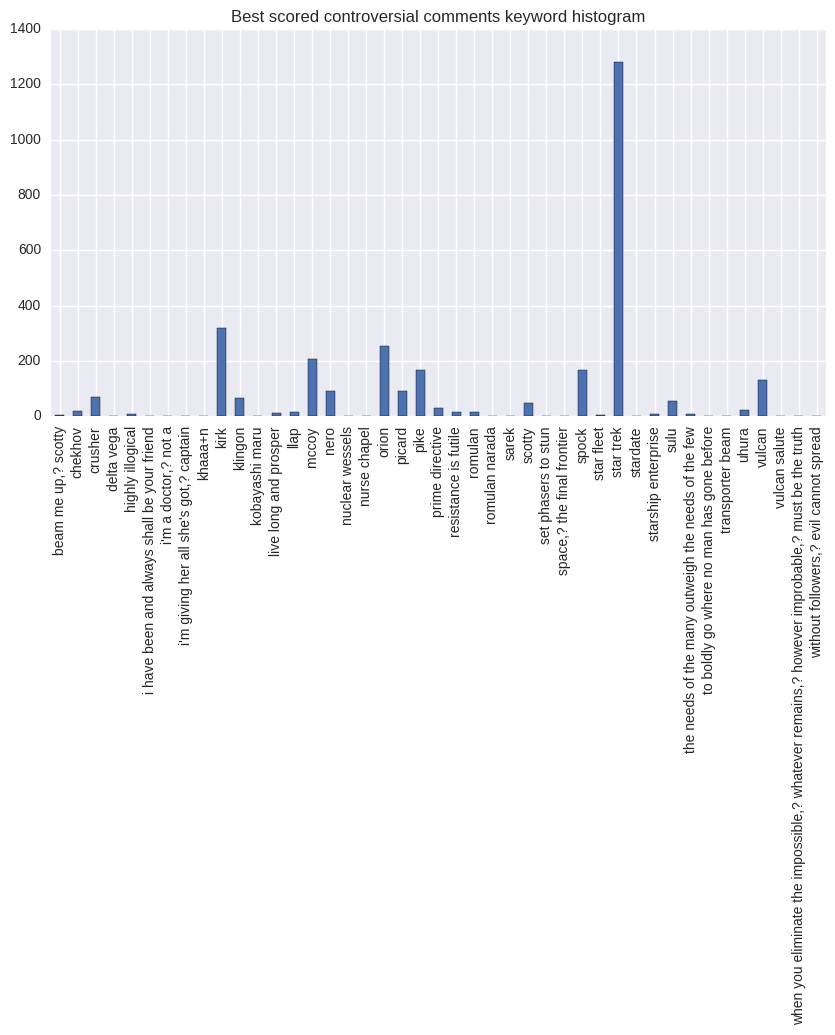

In [298]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Best scored controversial comments keyword histogram',
)

### Bottom

In [299]:
bottom_scored_controversial = controversial_df.sort_values(['score'], ascending=True)[:len(controversial_df) * P // 100]

In [300]:
len(bottom_scored_controversial)

2889

In [301]:
bottom_scored_controversial.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
2351321,SuckNFail,i'm going to repost it next week with this title.,1,2016-03-27 16:13:56,0,0,0,d1fjyml,0,t1_d1fc0c2,-64,AdviceAnimals,-64,2016-03-01,2016-01-01
2647448,canttrustacracker,i'll never understand the white mentality. lie...,1,2016-08-22 02:45:00,0,0,0,d6rksgu,0,t3_4yys0e,-64,4chan,-64,2016-08-01,2016-01-01
970001,Nickster93,yeah he already knew that. - edit 2: .......,1,2014-02-16 15:28:25,0,0.0,0,cfgwgoh,t1_cfgwgoh,t1_cfgw9rh,-62,AdviceAnimals,-62,2014-02-01,2014-01-01
2158127,djb85511,ahem bernie sanders 2016,1,2015-12-17 20:32:21,0,0,0,cy2wvq9,0,t1_cy2wutm,-46,AdviceAnimals,-46,2015-12-01,2015-01-01
2560744,Jewbaccah,no it's not boring. in fact that's exactly wha...,1,2016-07-16 11:44:45,0,0,0,d5emef1,0,t1_d5em7oz,-39,movies,-39,2016-07-01,2016-01-01


In [302]:
bottom_scored_controversial.ix[2351321]['body']

"i'm going to repost it next week with this title."

#### Temporal evolution

In [303]:
df_by_month = pd.Series(bottom_scored_controversial.groupby('month')['id'].count())
df_by_month.index.name = None

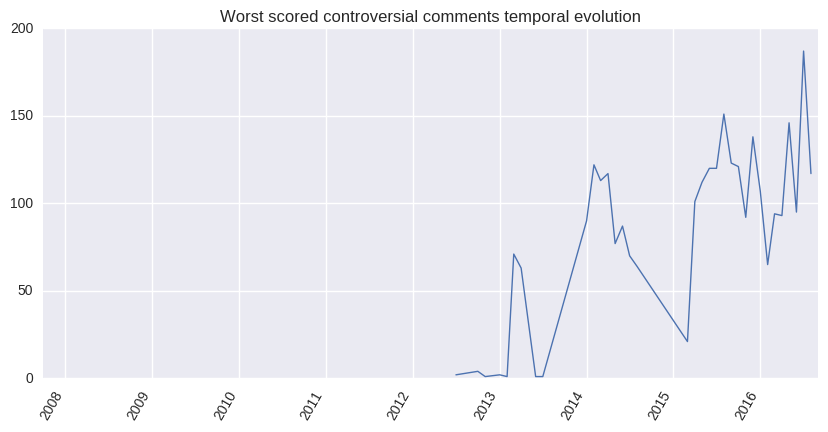

In [304]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=valid_dates,
    rot=60,
    title='Worst scored controversial comments temporal evolution',
)
# ax.set_xticklabels(show_dates);

#### Histogram

In [305]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = bottom_scored_controversial['body'].str.count(k).sum()

CPU times: user 198 ms, sys: 36.9 ms, total: 235 ms
Wall time: 179 ms


In [306]:
keywords_counter = Counter(keywords_dict)

In [307]:
keywords_counter.most_common()

[('star trek', 985),
 ('kirk', 331),
 ('mccoy', 237),
 ('orion', 220),
 ('vulcan', 141),
 ('pike', 136),
 ('spock', 105),
 ('nero', 104),
 ('picard', 94),
 ('scotty', 65),
 ('crusher', 60),
 ('sulu', 57),
 ('klingon', 47),
 ('resistance is futile', 32),
 ('uhura', 20),
 ('romulan', 19),
 ('prime directive', 18),
 ('the needs of the many outweigh the needs of the few', 9),
 ('live long and prosper', 9),
 ('highly illogical', 8),
 ('chekhov', 8),
 ('star fleet', 7),
 ('llap', 5),
 ('beam me up,? scotty', 4),
 ('starship enterprise', 4),
 ('kobayashi maru', 3),
 ('khaaa+n', 2),
 ('set phasers to stun', 1),
 ('delta vega', 1),
 ('space,? the final frontier', 1),
 ("i'm a doctor,? not a", 1),
 ('to boldly go where no man has gone before', 1),
 ('stardate', 0),
 ('vulcan salute', 0),
 ('nurse chapel', 0),
 ('without followers,? evil cannot spread', 0),
 ('romulan narada', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('transporter beam', 0),
 ('nuclear wessels', 0),
 ('i have been and

In [308]:
keywords_sr = pd.Series(keywords_dict)

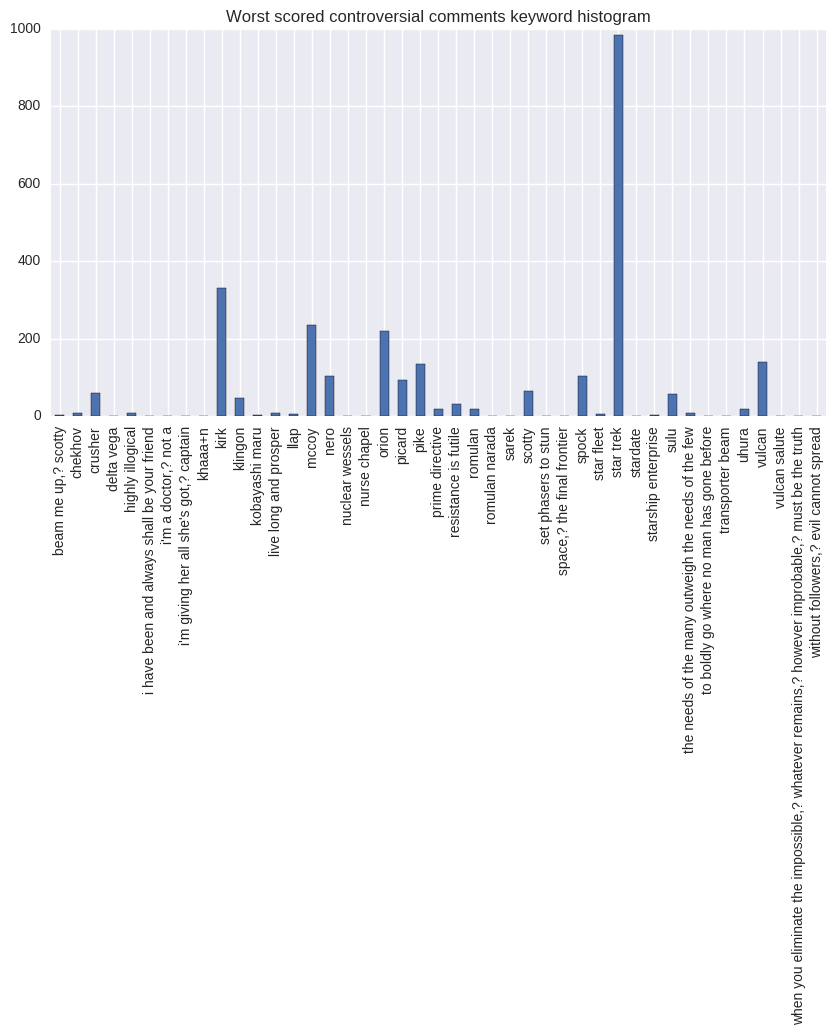

In [309]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Worst scored controversial comments keyword histogram',
)